In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   
#from Models import *
import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5j0n.mrc


NGLWidget()

In [26]:
file_name = './data/5j0n.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol1      = np.array(mrcVol.data) 
    ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(Vol1.shape)

(69, 57, 75)


In [27]:
import nglview as nv
PROTEIN = "5a1a"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map


5a1a.mrc


NGLWidget()

In [28]:
file_name = '5a1a.mrc'
with mrcfile.open(file_name) as mrcVol:
    Vol2      = np.array(mrcVol.data) 
    ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(Vol2.shape)

(110, 155, 199)


In [29]:
# Then make 2 vol the same size
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol1 = zoom(Vol1, (15/69, 15/57, 15/75))
print(Vol1.shape)
NewVol = np.zeros((20, 20, 20))
NewVol[:15, :15, :15] = Vol1
Vol1 = NewVol
ProjSize1 = int(np.sqrt(np.sum(np.square(Vol1.shape))))
print(ProjSize1)

Vol2 = zoom(Vol2, (15/110, 15/155, 15/199))
print(Vol2.shape)
NewVol = np.zeros((20, 20, 20))
NewVol[5:, 5:, 5:] = Vol2
Vol2 = NewVol
ProjSize2 = int(np.sqrt(np.sum(np.square(Vol2.shape))))
print(ProjSize2)

(15, 15, 15)
34
(15, 15, 15)
34


In [30]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [31]:
#Here we create Vol1 orthogonal to Vol2
"""
import copy 
print(Vol2.shape)
vecVol2 = Vol2.reshape(-1, order = 'F')
print(vecVol2.shape)
vecVol1 = copy.deepcopy(vecVol2)
for i in range(3375 - 1):
    if i % 2 == 0:
        vecVol1[i] = - vecVol2[i + 1]
    else:
        vecVol1[i] = vecVol2[i - 1]
vecVol1[-1] = 0
print(np.sum(vecVol1*vecVol2))
print(vecVol2[1500:1506])
print(vecVol1[1500:1506])
Vol1 = vecVol1.reshape(15, 15, 15 , order = 'F')
"""


"\nimport copy \nprint(Vol2.shape)\nvecVol2 = Vol2.reshape(-1, order = 'F')\nprint(vecVol2.shape)\nvecVol1 = copy.deepcopy(vecVol2)\nfor i in range(3375 - 1):\n    if i % 2 == 0:\n        vecVol1[i] = - vecVol2[i + 1]\n    else:\n        vecVol1[i] = vecVol2[i - 1]\nvecVol1[-1] = 0\nprint(np.sum(vecVol1*vecVol2))\nprint(vecVol2[1500:1506])\nprint(vecVol1[1500:1506])\nVol1 = vecVol1.reshape(15, 15, 15 , order = 'F')\n"

In [32]:
Projections1 = generate_projections_ASTRA(Vol1, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections1 = np.array(Projections1, dtype=dtype)

Projections2 = generate_projections_ASTRA(Vol2, angles2, ProjSize1, BatchSizeAstra = "None")
dtype = np.float32
Projections2 = np.array(Projections2, dtype=dtype)

0.030323733


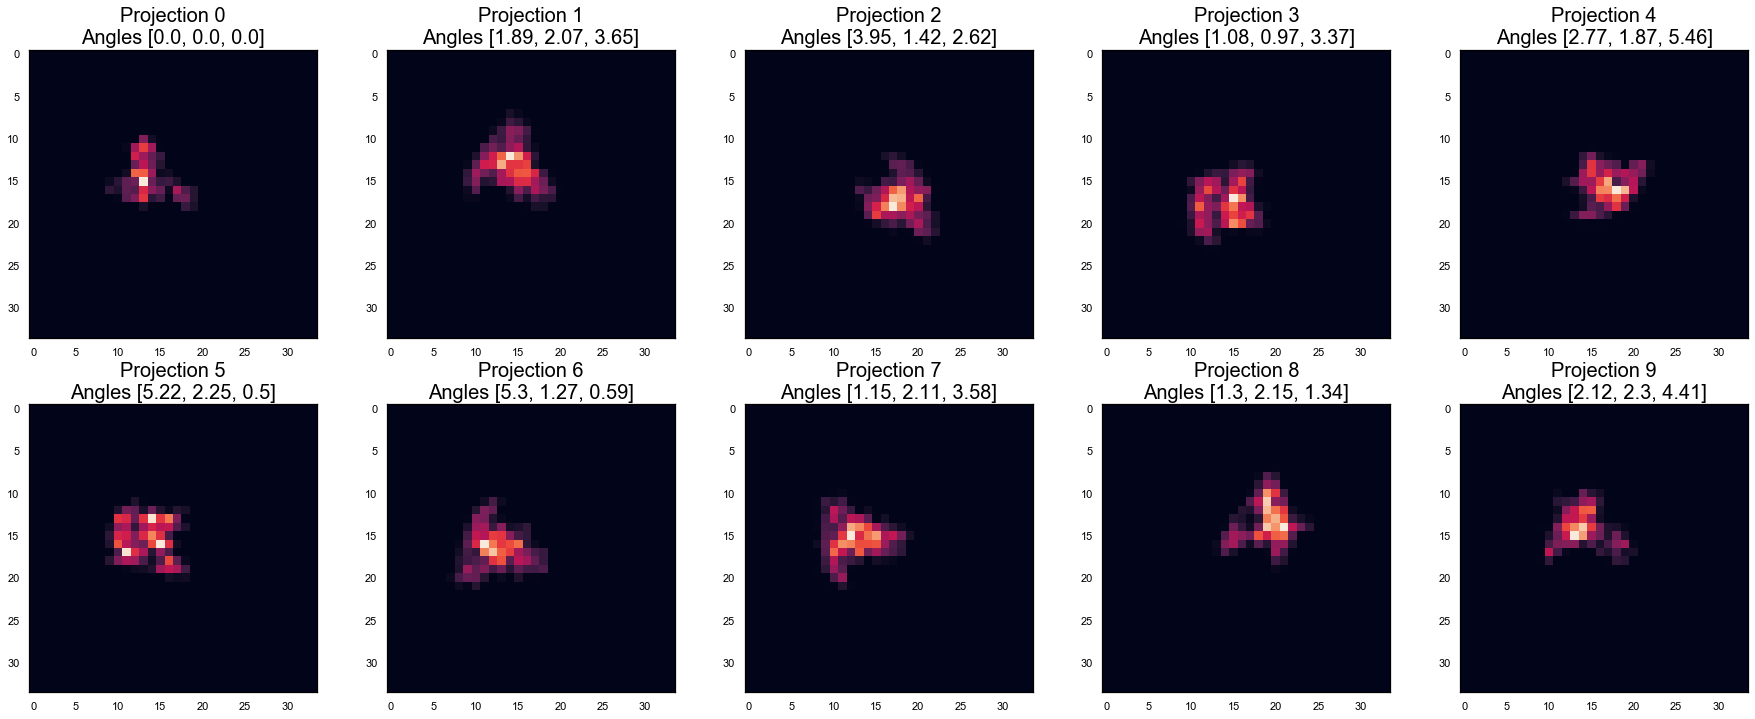

0.16001888


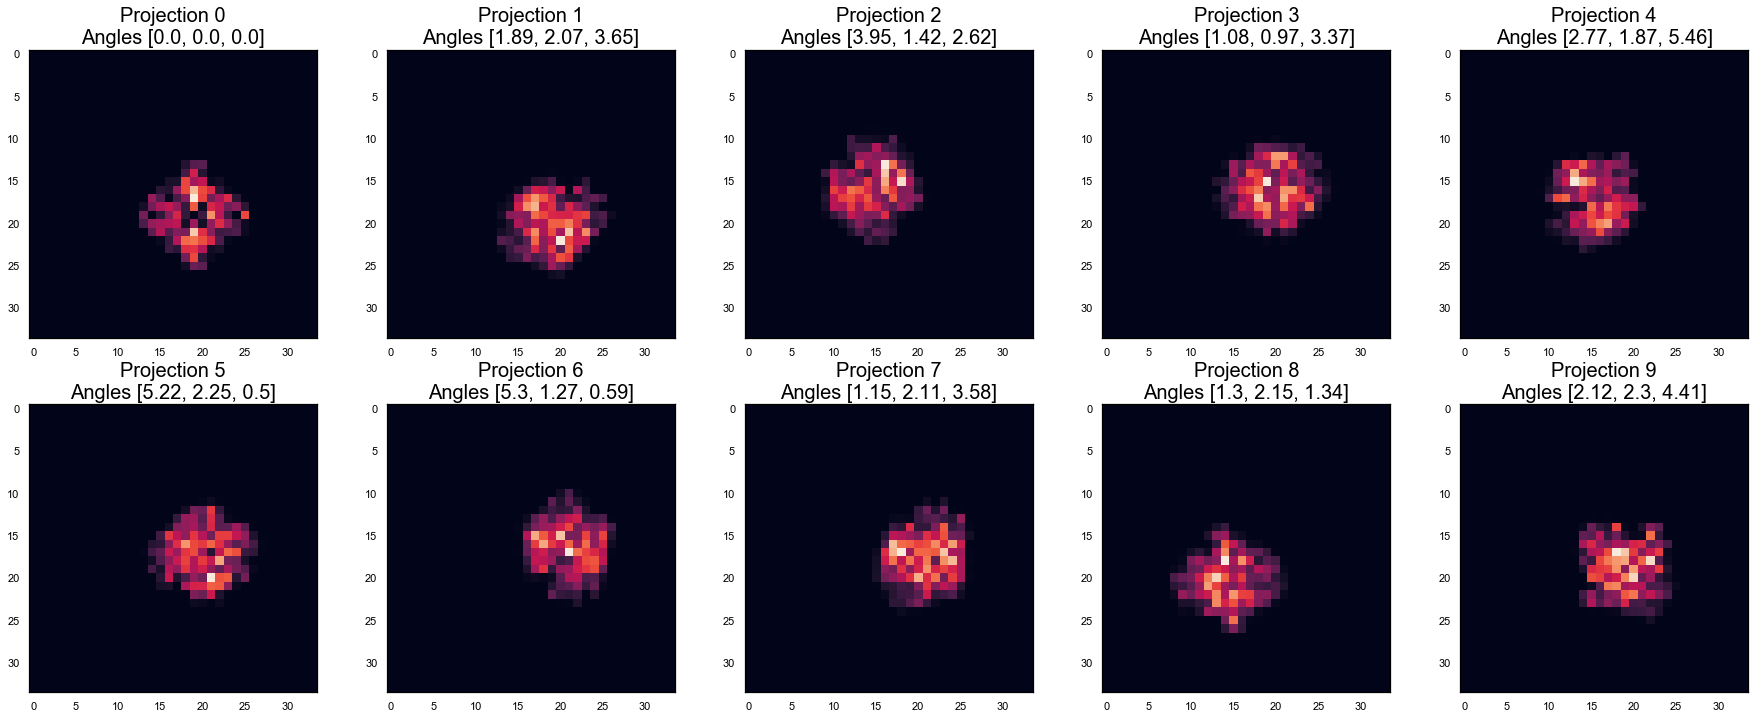

In [33]:
pids = range(10)
print(np.mean(Projections1))
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

pids = range(10)
print(np.mean(Projections2))
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [18]:
#BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [19]:
#print(BP_data.shape)
##print(BP_data[0].shape)
#print(Projections[0].shape)
#print(np.sum(BP_data[0] - Projections[0]))

In [20]:
#CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
#pids = range(10)
#plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

Before getting started, we now only get $\mu_s$, which should be mean subtracted. <br>
How about setting $\mu_s = 0$, and that $\mu_1 = vol$. <br>
Since for each image, $I_j = A_j (\mu_s + \mu z_j  )$ where $z_j \sim N(0,1)$ and we have $\mu_s = 0$,<br>
we have $I_j = A_j \mu z_j$
we can take $z_j$ out and make the formula : $I_j = z_j A_j \mu $


0.030323733


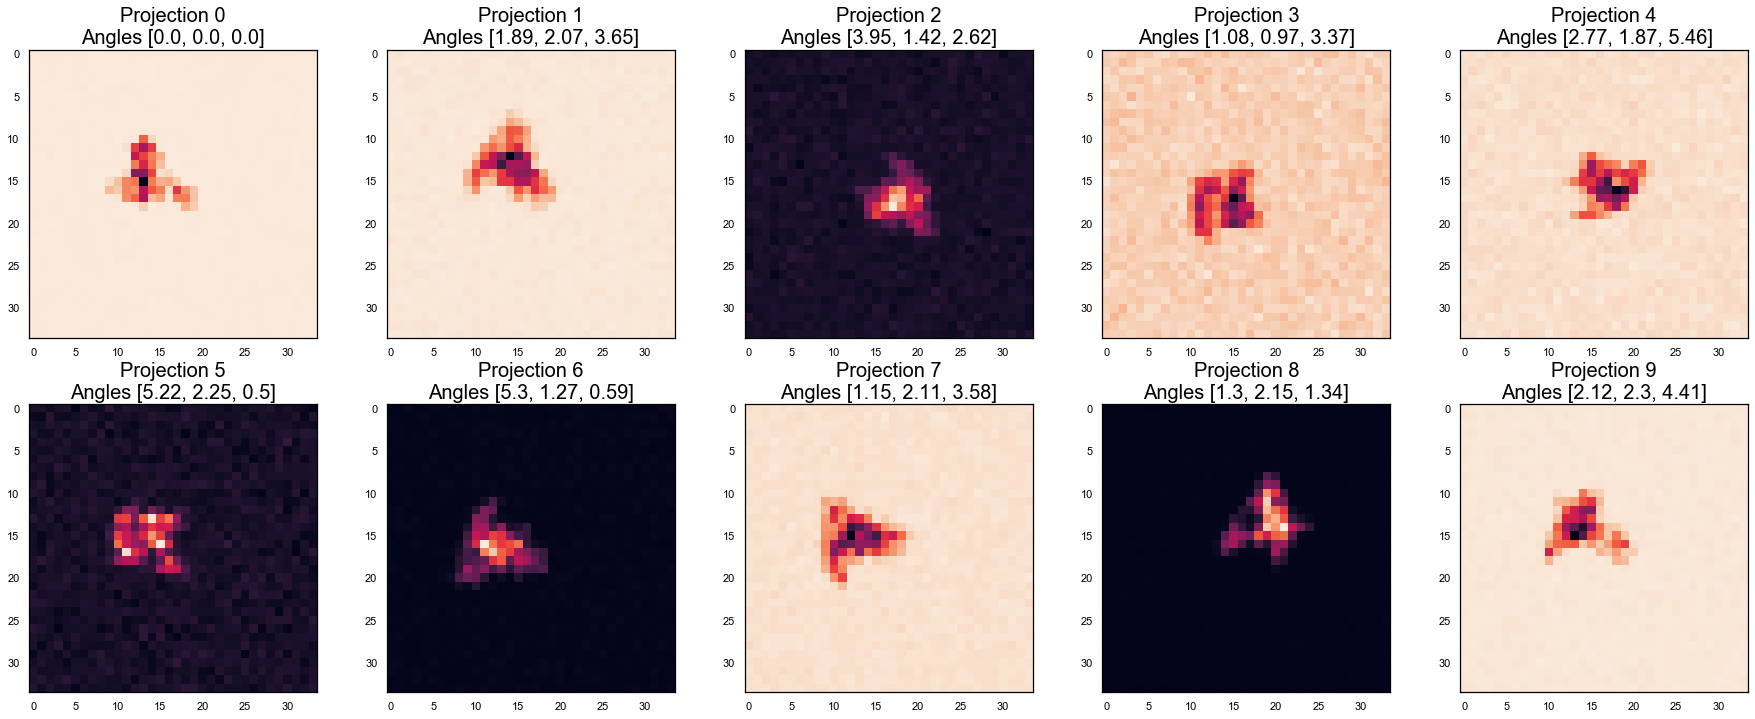

0.16001888


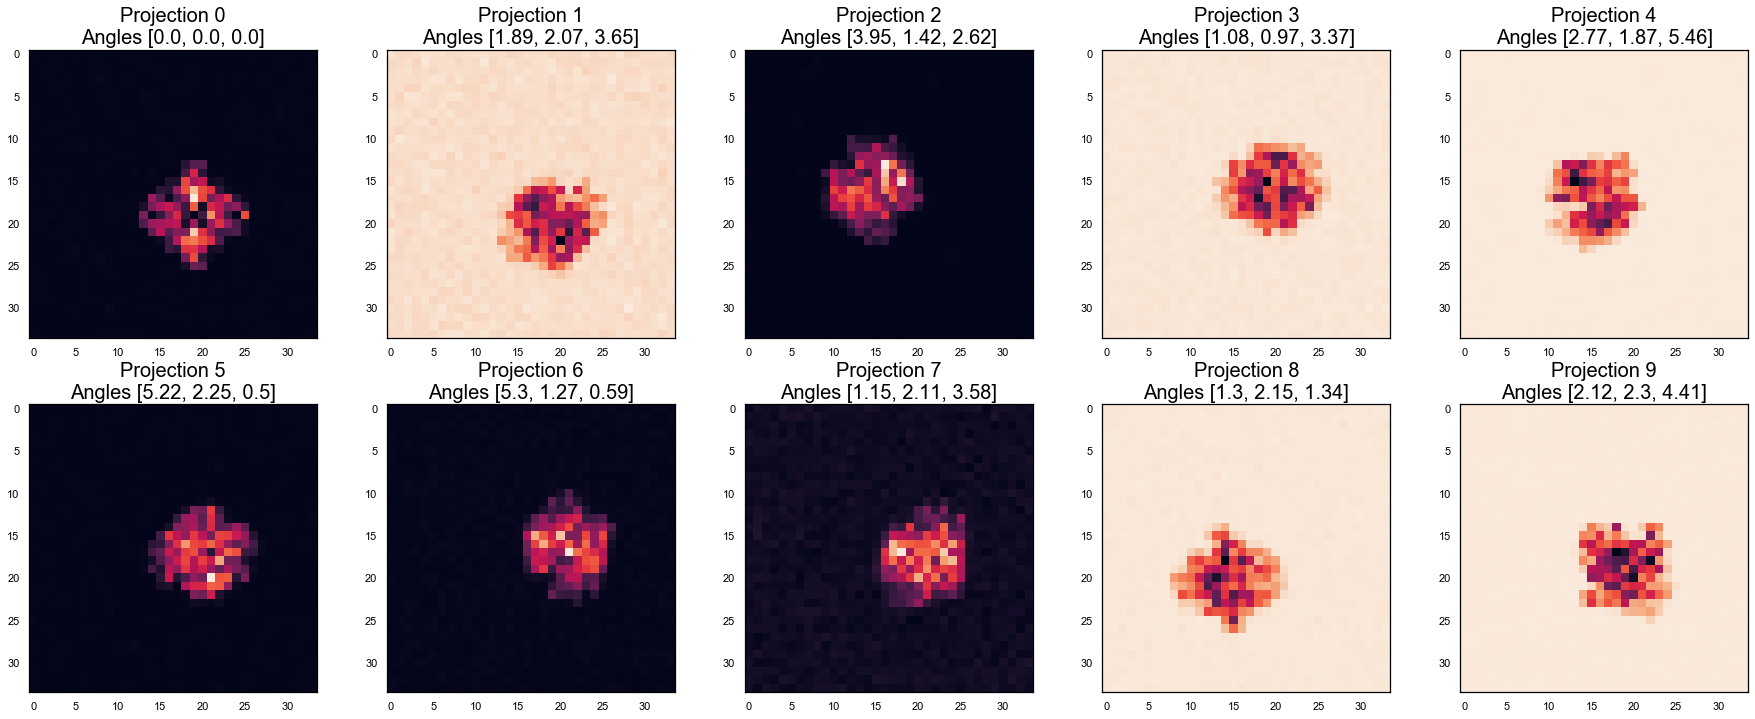

In [34]:
#Make I_j = z_j A_j mu
print(np.mean(Projections1))
True_z1 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_21 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections1 = Projections1 * True_z1

#add noise
for i in range(5000):
    Projections1[i] = Projections1[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_21[i]**(0.5)
plot_projections(Projections1[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

#Make I_j = z_j A_j mu
print(np.mean(Projections2))
True_z2 = np.random.randn(5000).reshape(5000, 1, 1) 
True_sigma_22 = np.abs(np.random.randn(5000)) * 0.0001 # mean = 0.055


Projections2 = Projections2 * True_z2

#add noise
for i in range(5000):
    Projections2[i] = Projections2[i] + np.random.randn(ProjSize1, ProjSize1) * True_sigma_22[i]**(0.5)
plot_projections(Projections2[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)



In [35]:
new_projection = Projections2 + Projections1

In [46]:
#Write a recurssive function
#Input Found mu_1, ..., mu_n-1, now_n, n_components, 

class PCA_3d_Recon_recurssive():
    def __init__(self, ProjSize, num_image, n_component, Mus = None):
        
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component

        #if Mus == None:
        ##    #This means that we are at the first iteration
        #    self.Now_n = 1
        #else:
        #We want to find the +1 component
        self.Now_n = Mus.shape[0] + 1
        
        self.Mus = np.zeros((self.Now_n, ProjSize, ProjSize, ProjSize)) + 0.00001
        self.Mus[: self.Now_n -1  , :, :, :] = Mus #Record the previous conponents
        self.sigma = np.ones(self.num_image) * 0.1


        self.ro = np.abs(np.ones((num_image, self.Now_n)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.Now_n, self.Now_n )))

        self.Aus = np.zeros(( num_image, ProjSize* ProjSize,  self.Now_n))

    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Q_(Imgages, Angles)
        self.Plot_mu_by_projection(Angles)
        for i in range(160 * 50):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            self.Q_(Imgages, Angles)
            if i % 50 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
                self.Q_(Imgages, Angles)
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        for n in range(self.Now_n):
            Projections = generate_projections_ASTRA(self.Mus[n] , Angles, self.ProjSize, BatchSizeAstra = "None")
            #print(Projections.shape)
            #check_image = Projections[0].reshape(-1, 1, order = 'F')
            self.Aus[:, :, n] =  Projections.reshape(Projections.shape[0], -1 , order = 'F') #with fortrain - like order
            #print('check_Aus', check_image)
   
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        #self.Au_s(Angles)
        #ro = [] #For n image, we have n z.
        ro = np.zeros((self.num_image, self.Now_n ))
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            #ro.append(roj.tolist())
            ro[j] = roj.reshape(-1)
        #self.ro = np.array(ro).reshape(-1, self.Now_n) #Check@@@@@@@@@@
        self.ro = ro
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.Now_n, self.Now_n ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.Now_n) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.Now_n) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.Now_n , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])

    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.Now_n):
                right_term += right_term + self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]
                #print((self.Aus[j][: , i]*self.BigSigma[j][i][self.Now_n -1]).shape)
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.Now_n-1]
            #print('left_term', np.mean(left_term))
            #print(' self.ro[j][self.Now_n-1]' , self.ro[j][self.Now_n-1])
            temp = left_term - right_term.reshape(-1,1 , order = 'F')
            #print('left, right', np.mean(left_term), np.mean(right_term) )
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print('DeltaMu', np.mean(DeltaMu))
        #Before returning this ,since we should make the grident direction orthogonal to the previous directions, we should make
        #it orthogonal to the spam of mus
        PDeltaMu = DeltaMu.reshape(-1,1, order ='F')
        
        OriDeltaMu =  DeltaMu.reshape(-1,1, order ='F')
        Vec_Mus = self.Mus.reshape(self.Now_n, -1, 1, order = 'F')
        for i in range(self.Now_n -1):
            #print('Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu',(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu).shape)
            #print((Vec_Mus[i]*(Vec_Mus[i].T / np.linalg.norm(Vec_Mus[i]) @ OriDeltaMu)).shape)
            #print(PDeltaMu.shape)
            PDeltaMu = PDeltaMu - Vec_Mus[i]*(Vec_Mus[i].T @ OriDeltaMu / (np.linalg.norm(Vec_Mus[i]) **2))
        
        
        #print('check projected direction orthogonal mu[0]', np.sum(Vec_Mus[0] *PDeltaMu ))
        return PDeltaMu.reshape(self.ProjSize, self.ProjSize, self.ProjSize , order ='F')

    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(np.abs(self.Mus[self.Now_n -1])))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.Mus[self.Now_n -1] ) / np.mean(DeltaMu) )*0.001
            #print('lr', lr)
            self.Mus[self.Now_n -1] = self.Mus[self.Now_n -1] + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
            
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] @ self.ro[j].reshape(self.Now_n , 1)
            
            #right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            right = 0
            for x in range(self.Now_n):
                for y in range(self.Now_n):
                   right = right + self.Aus[j][: , x].T @ self.Aus[j][: , y] * self.BigSigma[j][x][y]
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        for n in range(self.Now_n):
            curremt_mu = self.Mus[n].reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
            CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
            pids = range(10)
            plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)

    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Aus[j][: ,self.Now_n - 1].reshape(-1, 1, order = 'F') * self.ro[j][self.Now_n - 1]

            #Aju =  self.Aus[j]
            #right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            right = 0
            for i in range(self.Now_n -1):
                right = right + self.Aus[j][:, i].T @ self.Aus[j][:, i] * self.BigSigma[j][i][self.Now_n - 1]
            right = right + 1/2 *  self.Aus[j][:, self.Now_n - 1].T @ self.Aus[j][:, self.Now_n - 1] * self.BigSigma[j][self.Now_n -1][self.Now_n -1]

            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass



class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.zeros((ProjSize, ProjSize, ProjSize)) + 0.01
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.ones((num_image, n_component)))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))

        self.Aus = np.zeros((n_component, num_image, ProjSize* ProjSize, 1))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        print('The 0-th iteration')
        self.Plot_mu_by_projection(Angles)
        for i in range(250):

            self.Expectation(Imgages, Angles)
            
            self.Maximization(Imgages, Angles)
            #self.Q_(Imgages, Angles)
            if i % 50 == 0:
            #    print(i)
                print(f'The {i+1}-th iteration')
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        #print(self.ro[:5])
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
              
        
    def Maximization(self, Images, Angles):
        #First update mu
        lr = 1e-8 * 2
        for i in range(5):
            #print('sigma',self.sigma[0])
            self.Au_s(Angles)
            #self.Q_(Images, Angles)
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('np.mean(DeltaMu)', np.mean(DeltaMu))
            #print('self.mu', np.mean(self.mu))
            #print('ratio',  np.mean(self.mu) / np.mean(DeltaMu) )
            lr = np.abs(np.mean(self.mu) / np.mean(DeltaMu) )*0.001
            self.mu = self.mu + lr * DeltaMu #Gradient ascent
            self.Update_sigma(Images, Angles)
        self.Au_s(Angles)
            
        #print(self.mu)
        pass
    def Update_sigma(self, Images, Angles):
        #self.sigma = 0 
        for j in range(self.num_image):
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ Ij - 2 * Ij.T @ self.Aus[j] * self.ro[j][self.n_component-1]
            
            right = self.Aus[j].T @ self.Aus[j] *self.BigSigma[j][0][0]
            
            self.sigma[j] = (1 / self.ProjSize **2 * (left + right ) ) ** 0.5 
            #for x in range(self.n_component):
            #    for y in range(self.n_component):
                    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
   
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(self.ProjSize , self.ProjSize,self.ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], self.ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


input noised image 


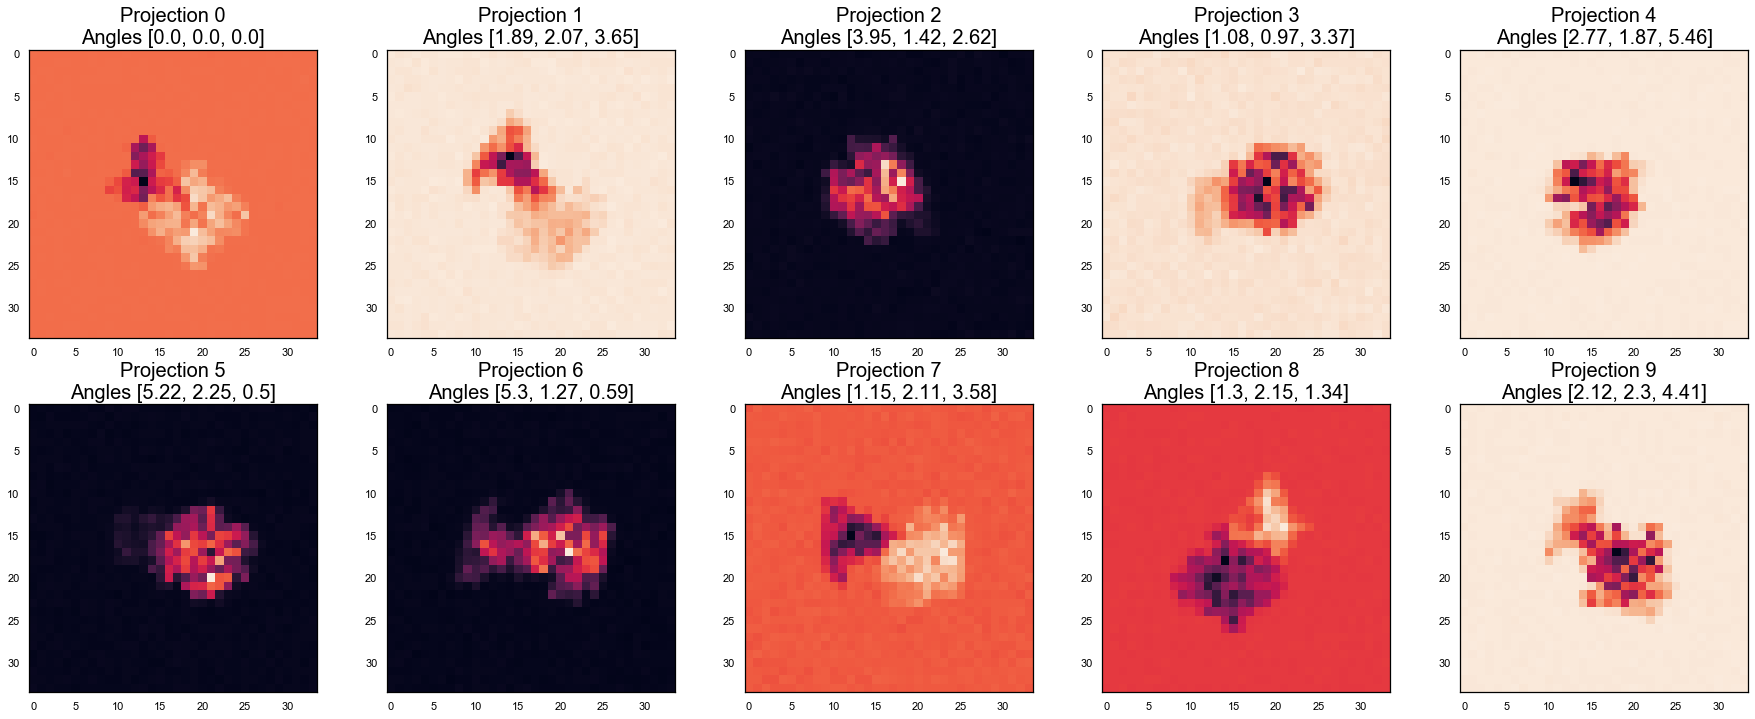

start fitting
The 0-th iteration


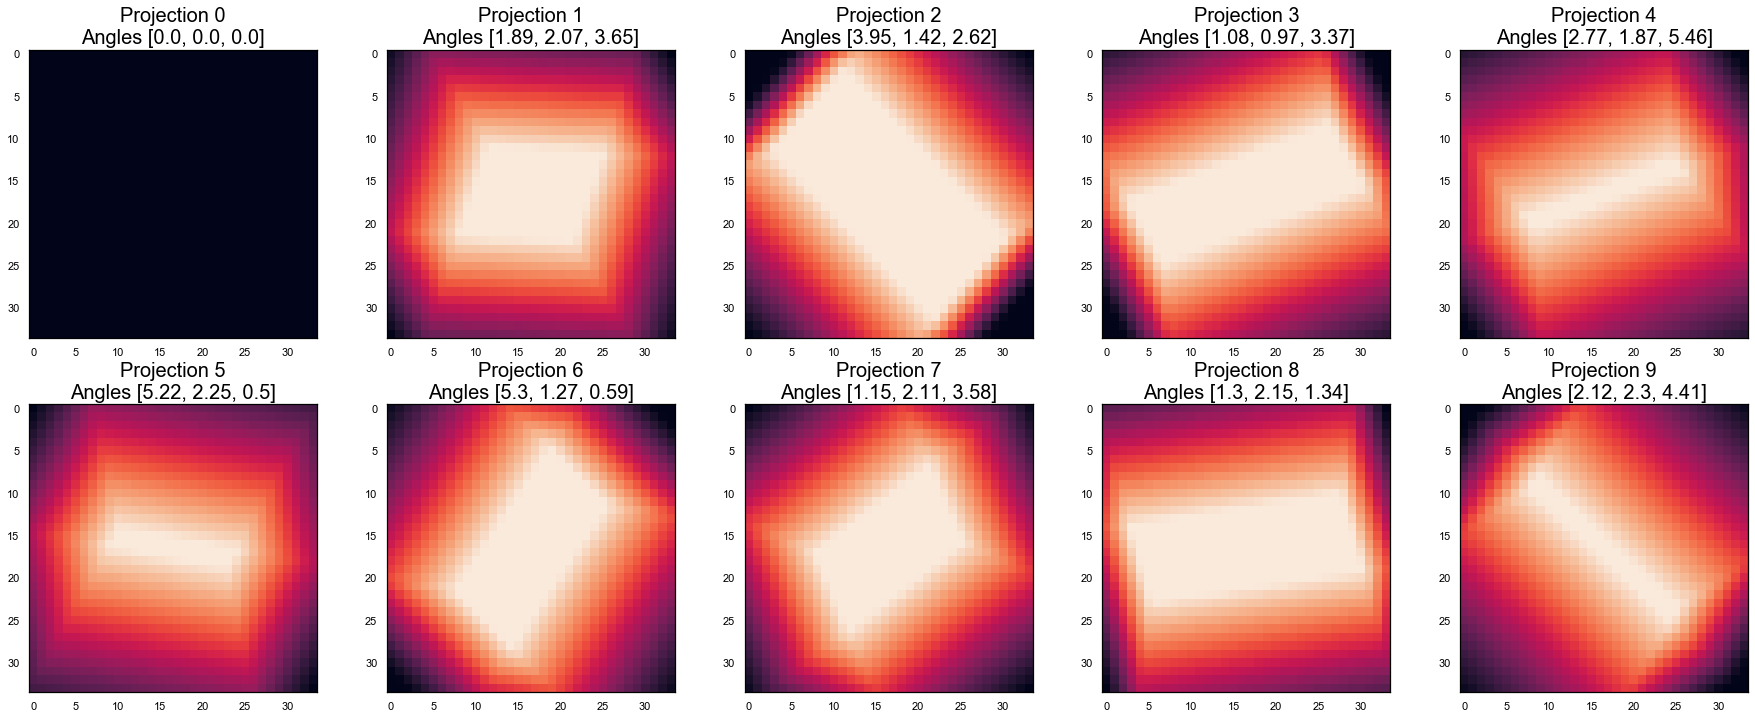

The 1-th iteration


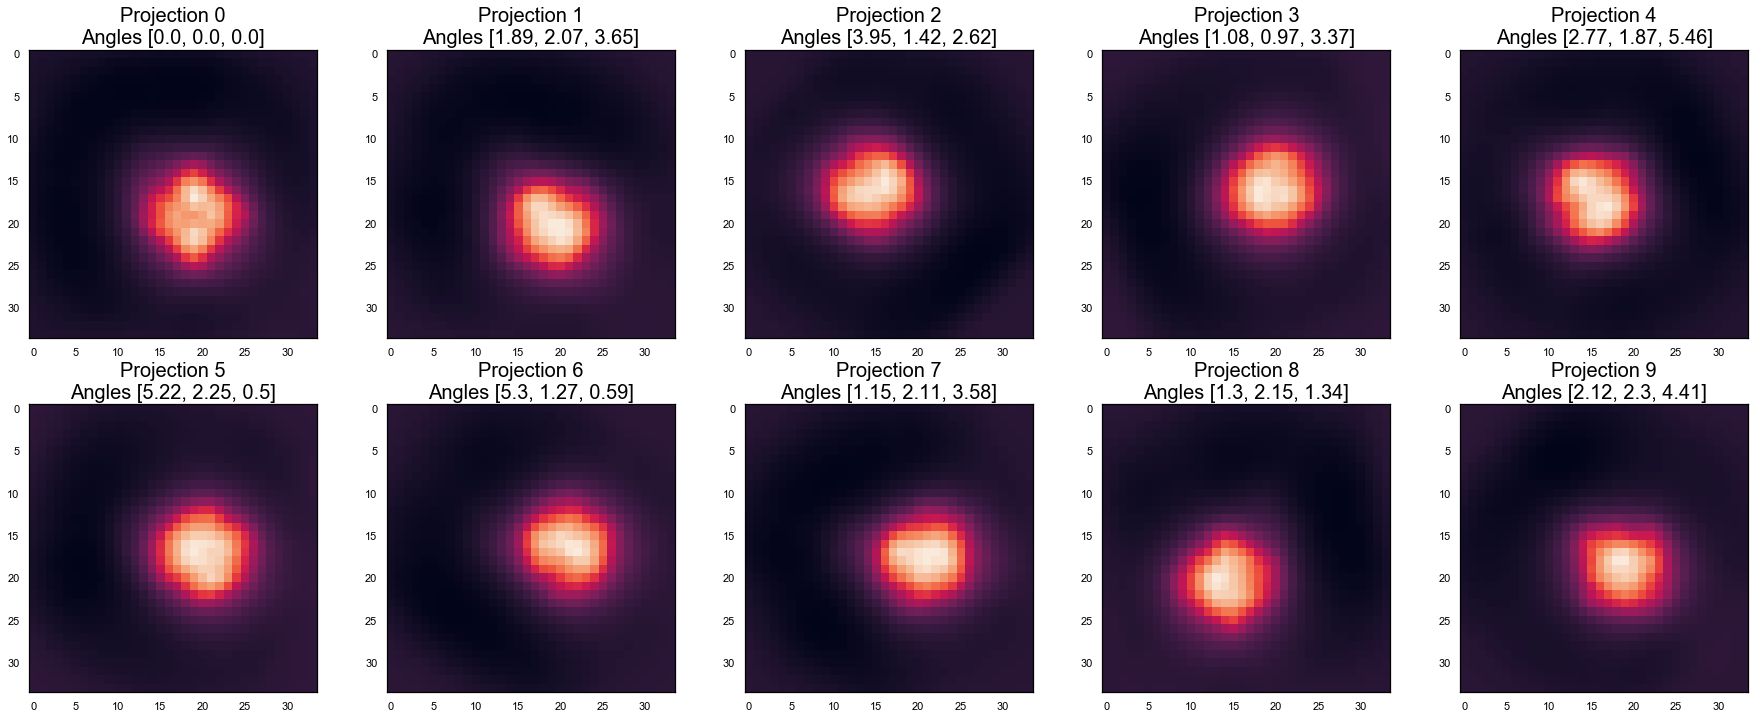

The 51-th iteration


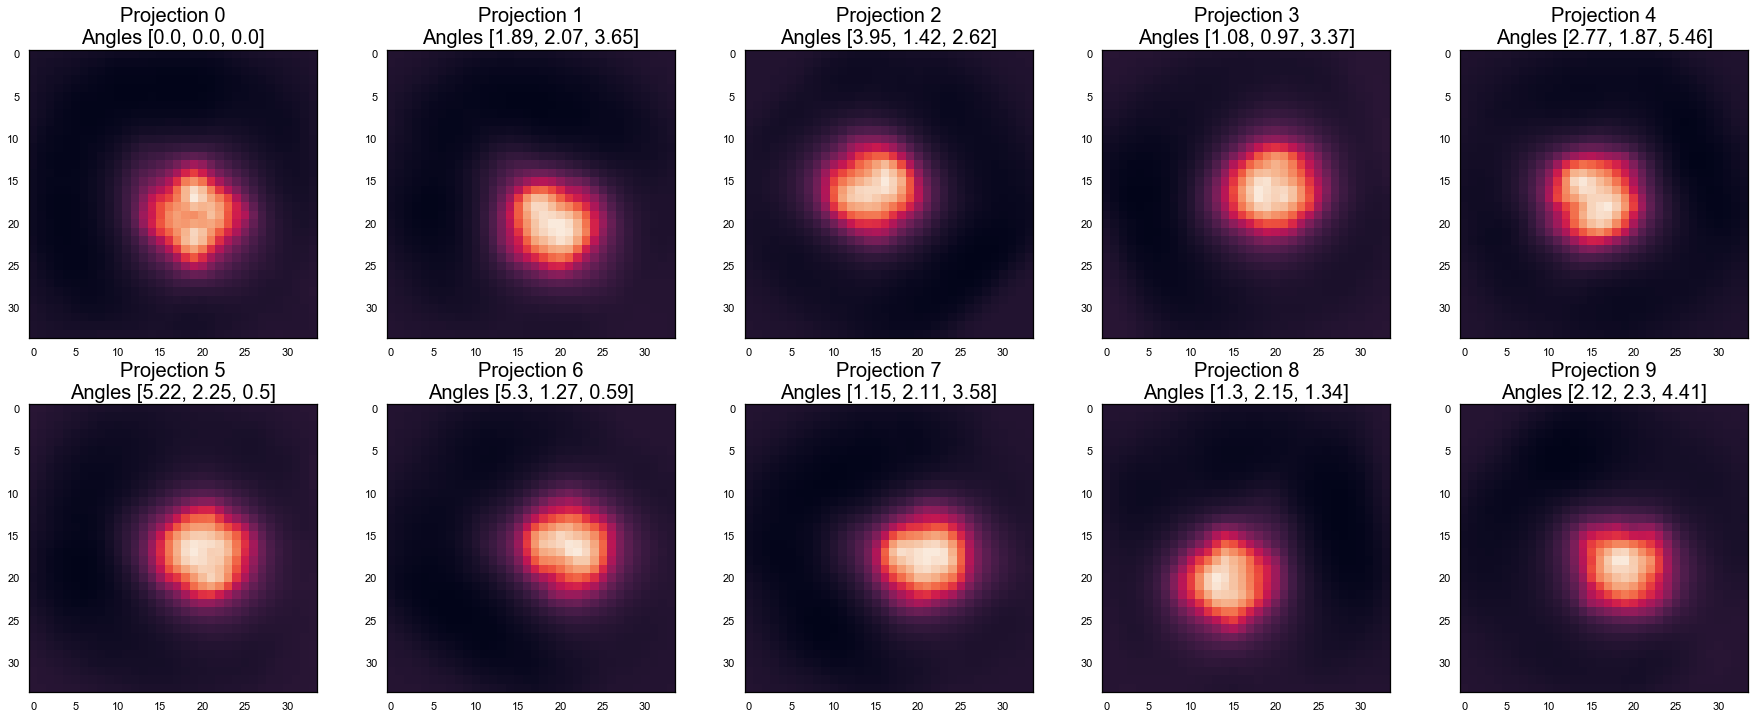

The 101-th iteration


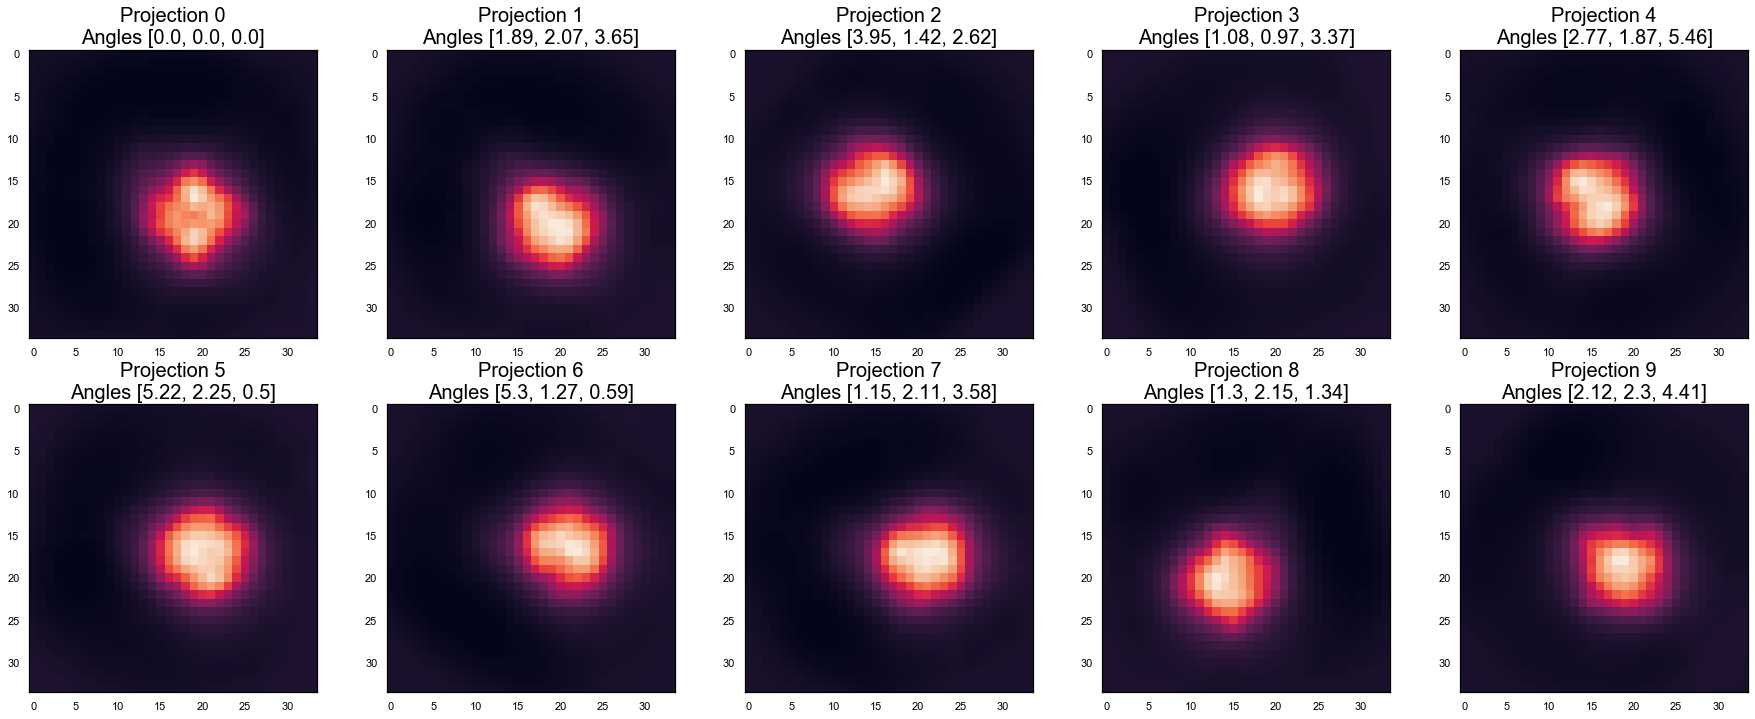

The 151-th iteration


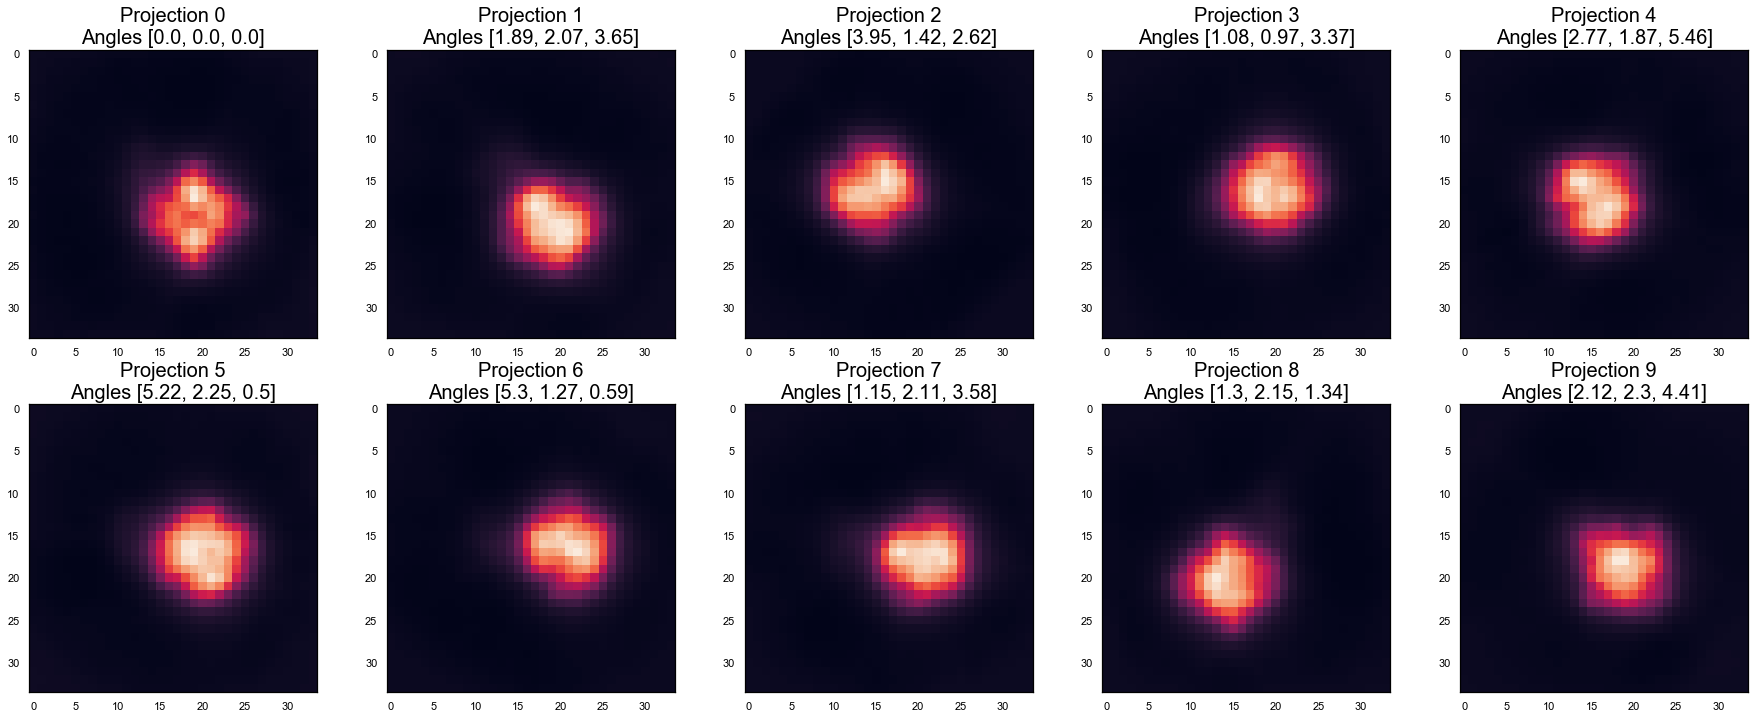

The 201-th iteration


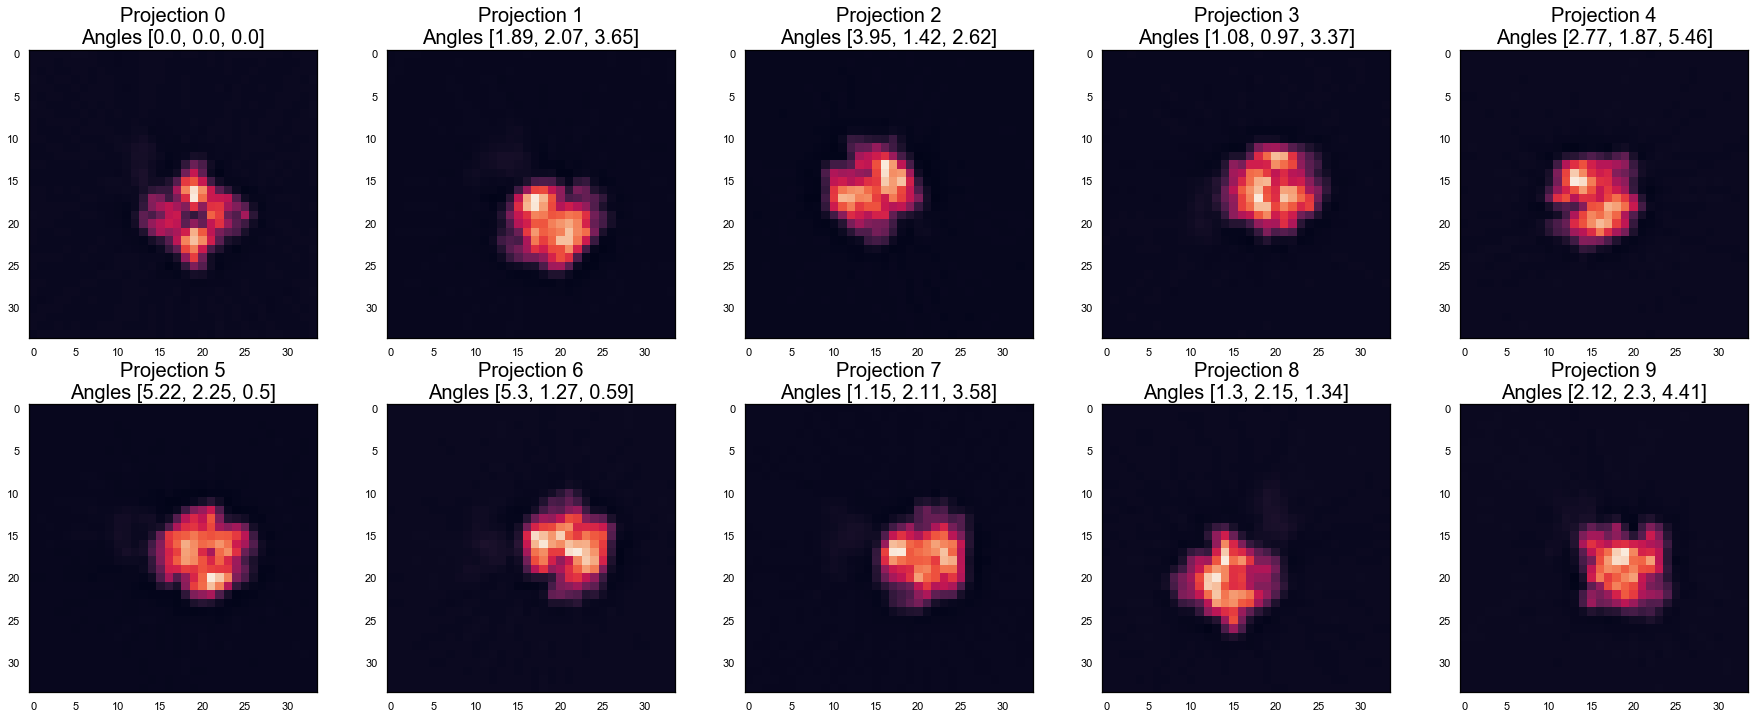

In [47]:



_, num_image , n_component = 116, 5000 , 1
angles2 = angles2[:num_image]
new_projection = new_projection[:num_image]
print('input noised image ')
plot_projections(new_projection[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

P3R = PCA_3d_Recon(ProjSize1, num_image, n_component)
P3R.Au_s(angles2)

P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)

In [48]:
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)
#P3R.fit(new_projection, angles2)


(34, 34, 34)
34
(5000, 1156, 2)
start fitting
The 0-th iteration
Q -1638520655.8612318


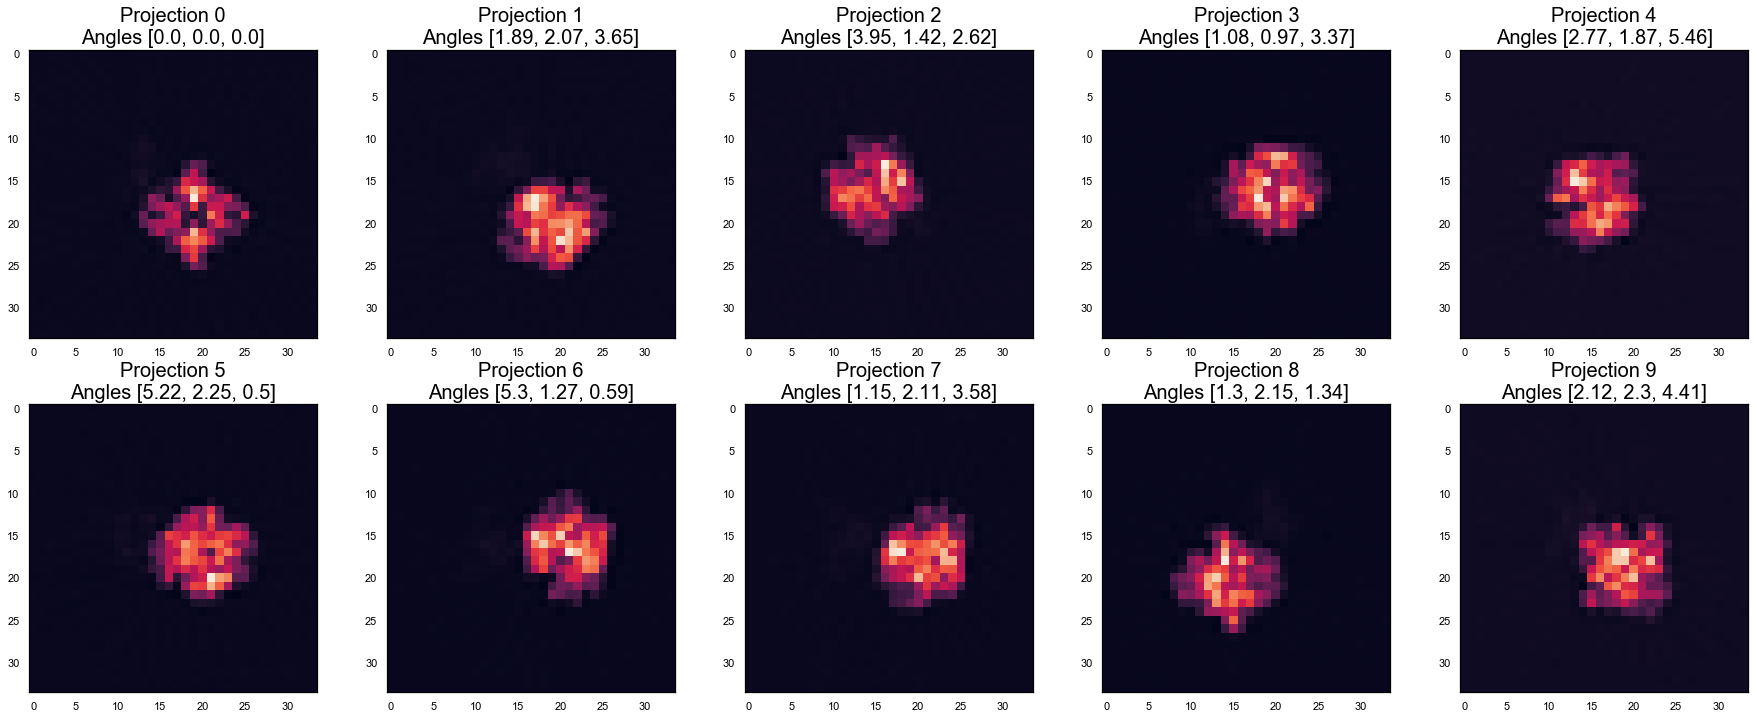

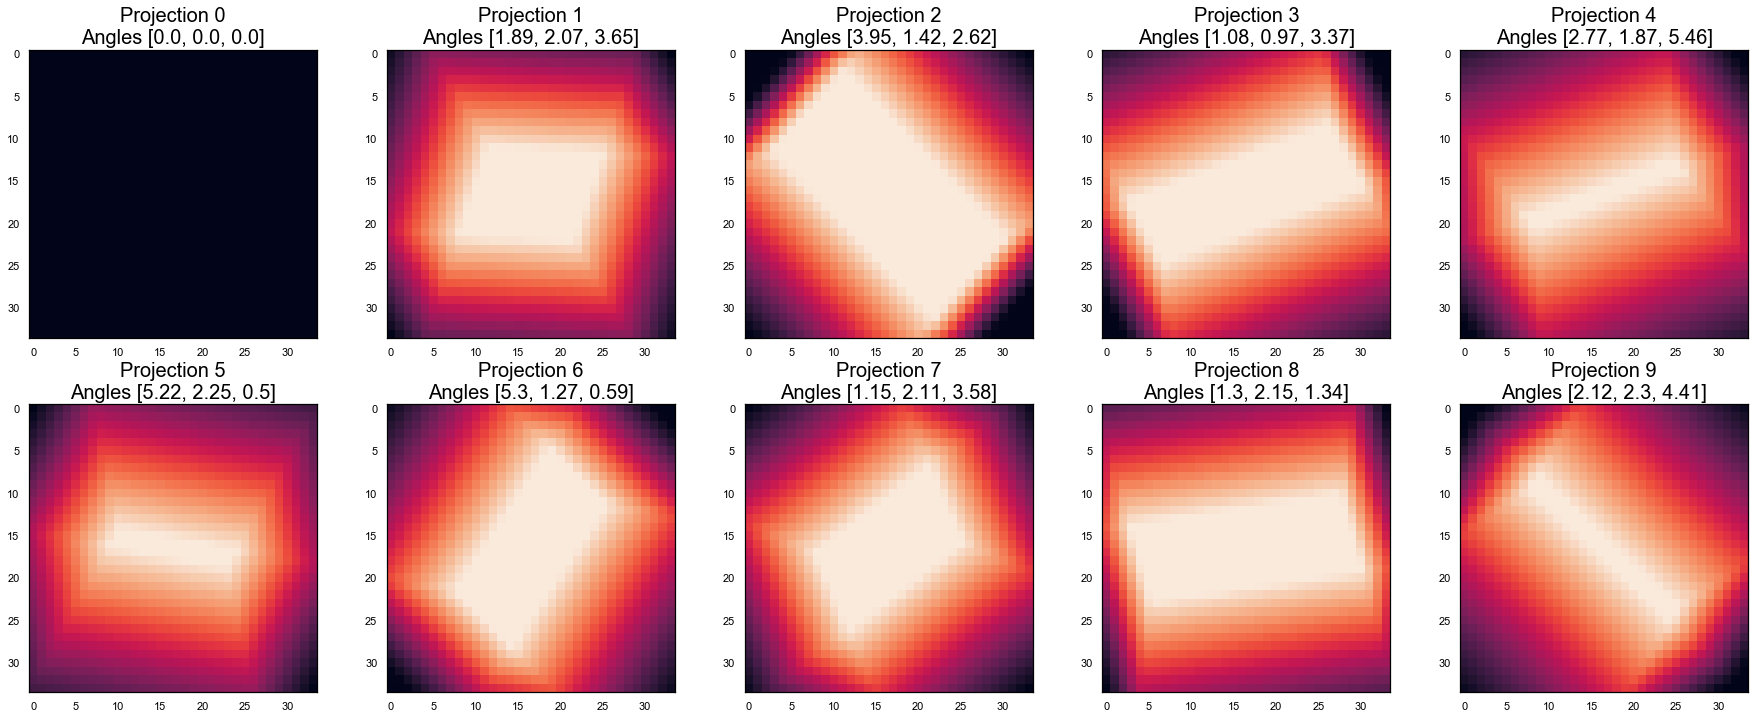

Q 16170284.711985866
delta Q 1654690940.5732176
The 1-th iteration


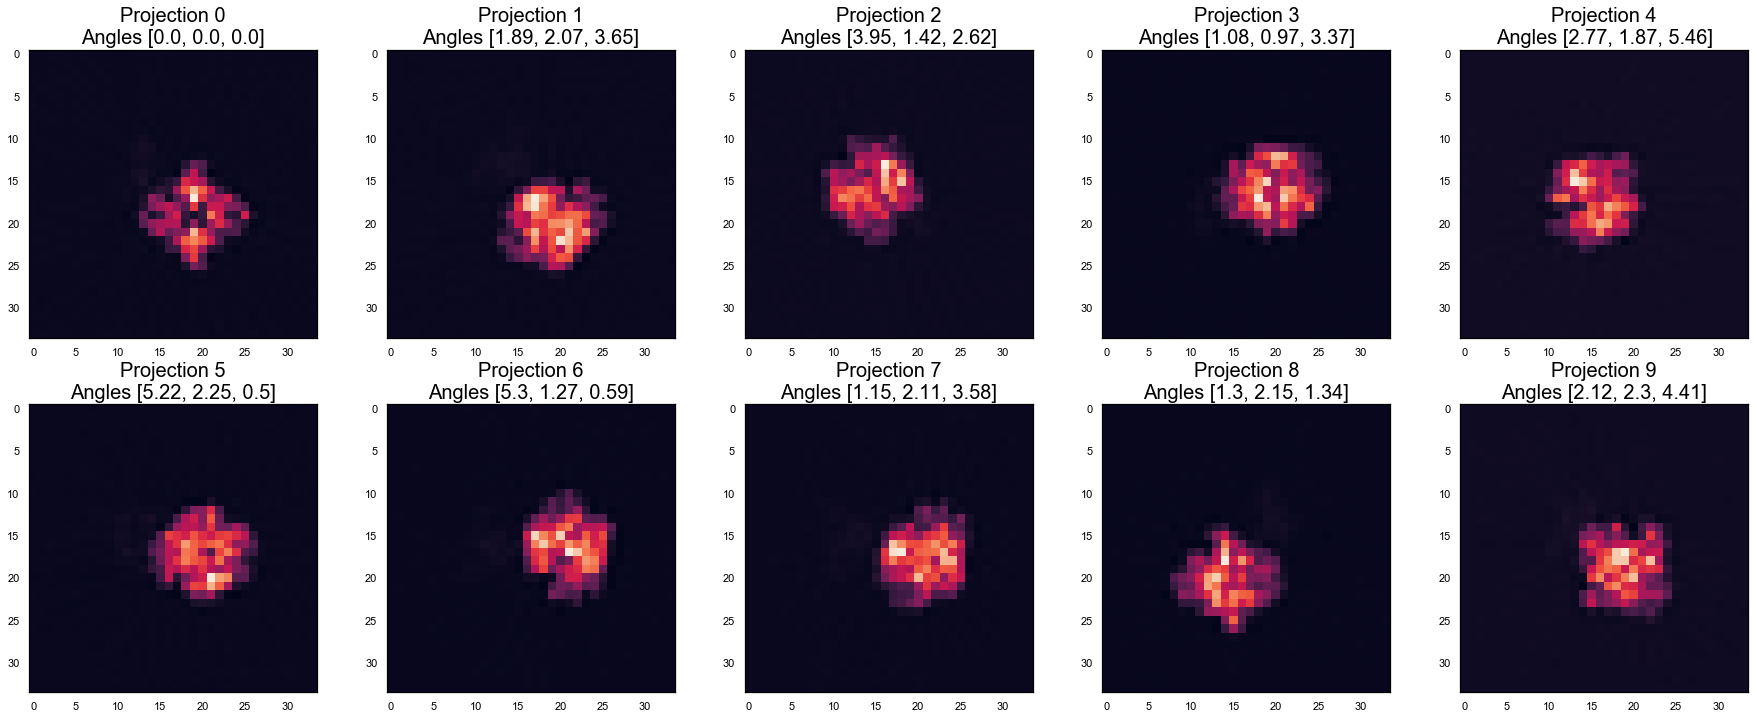

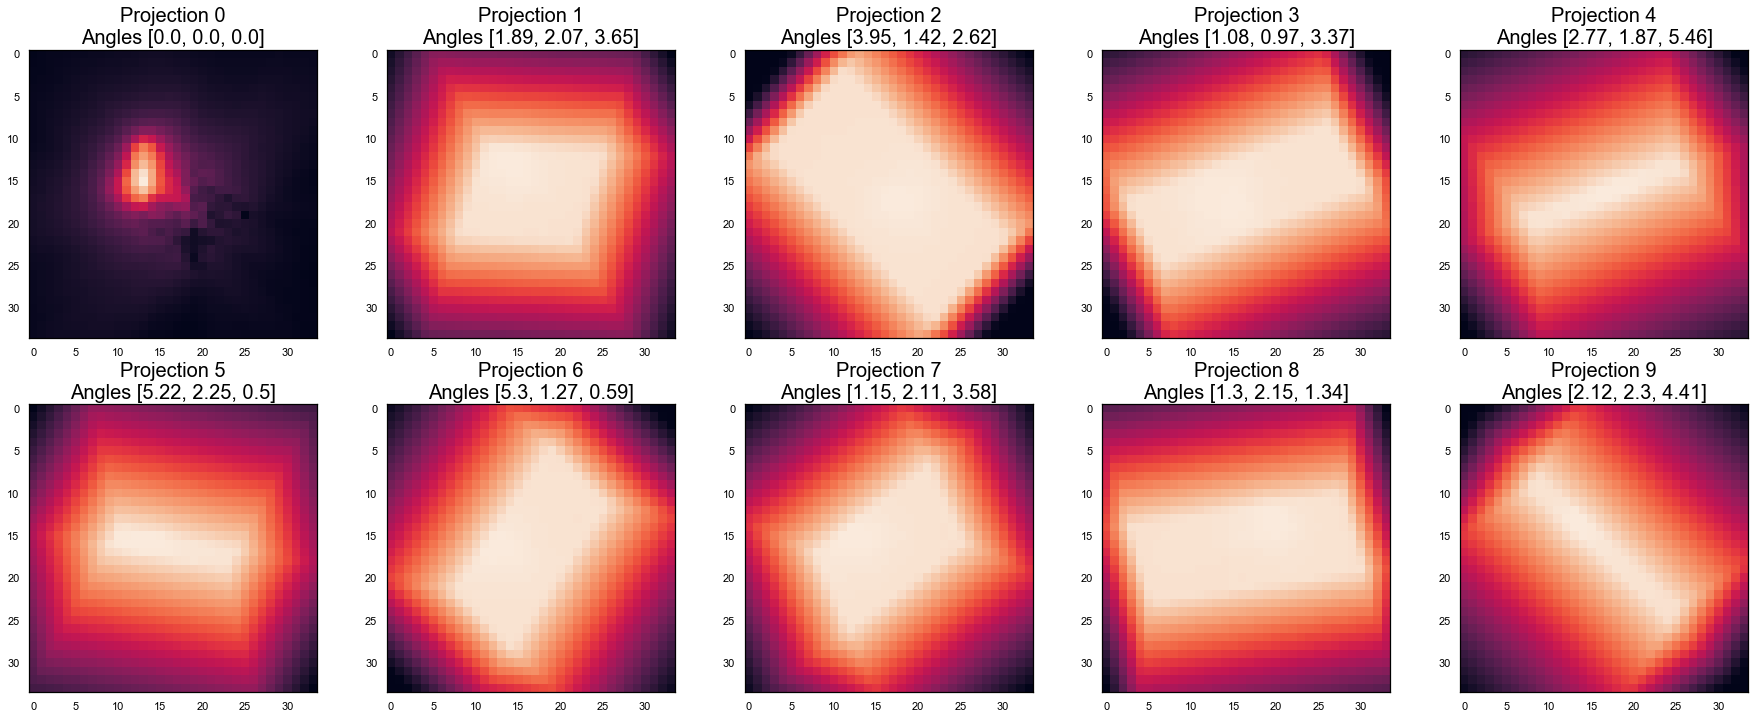

Q 16170284.711985866
delta Q 0.0
Q 32224701.014286723
delta Q 16054416.302300857
Q 33096954.086121853
delta Q 872253.0718351305
Q 33754773.826411664
delta Q 657819.740289811
Q 34415967.300629206
delta Q 661193.4742175415
Q 35080745.560996324
delta Q 664778.2603671178
Q 35749140.46329058
delta Q 668394.9022942558
Q 36421180.90266387
delta Q 672040.439373292
Q 37096901.885992534
delta Q 675720.9833286628
Q 37776340.08198213
delta Q 679438.1959895939
Q 38459527.31102134
delta Q 683187.2290392146
Q 39146501.76549567
delta Q 686974.45447433
Q 39837296.05770537
delta Q 690794.2922096997
Q 40531949.75871997
delta Q 694653.7010146007
Q 41230497.84734486
delta Q 698548.0886248872
Q 41932974.66280626
delta Q 702476.8154613972
Q 42639425.70417646
delta Q 706451.0413702056
Q 43349881.477109775
delta Q 710455.7729333118
Q 44064385.04050473
delta Q 714503.5633949563
Q 44782975.824850515
delta Q 718590.7843457833
Q 45505689.20703684
delta Q 722713.3821863234
Q 46232569.27327606
delta Q 726880.0662392

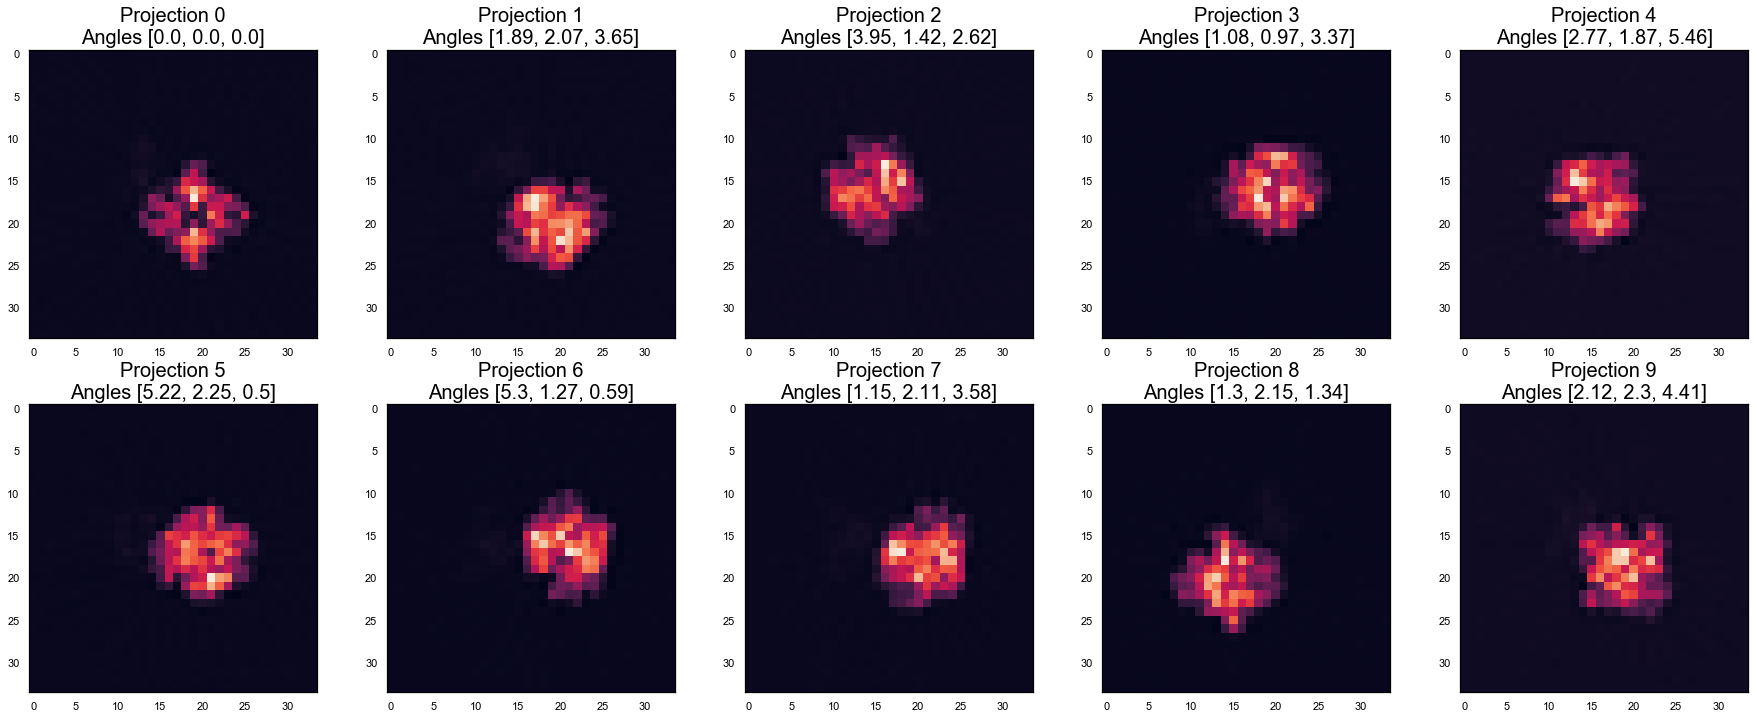

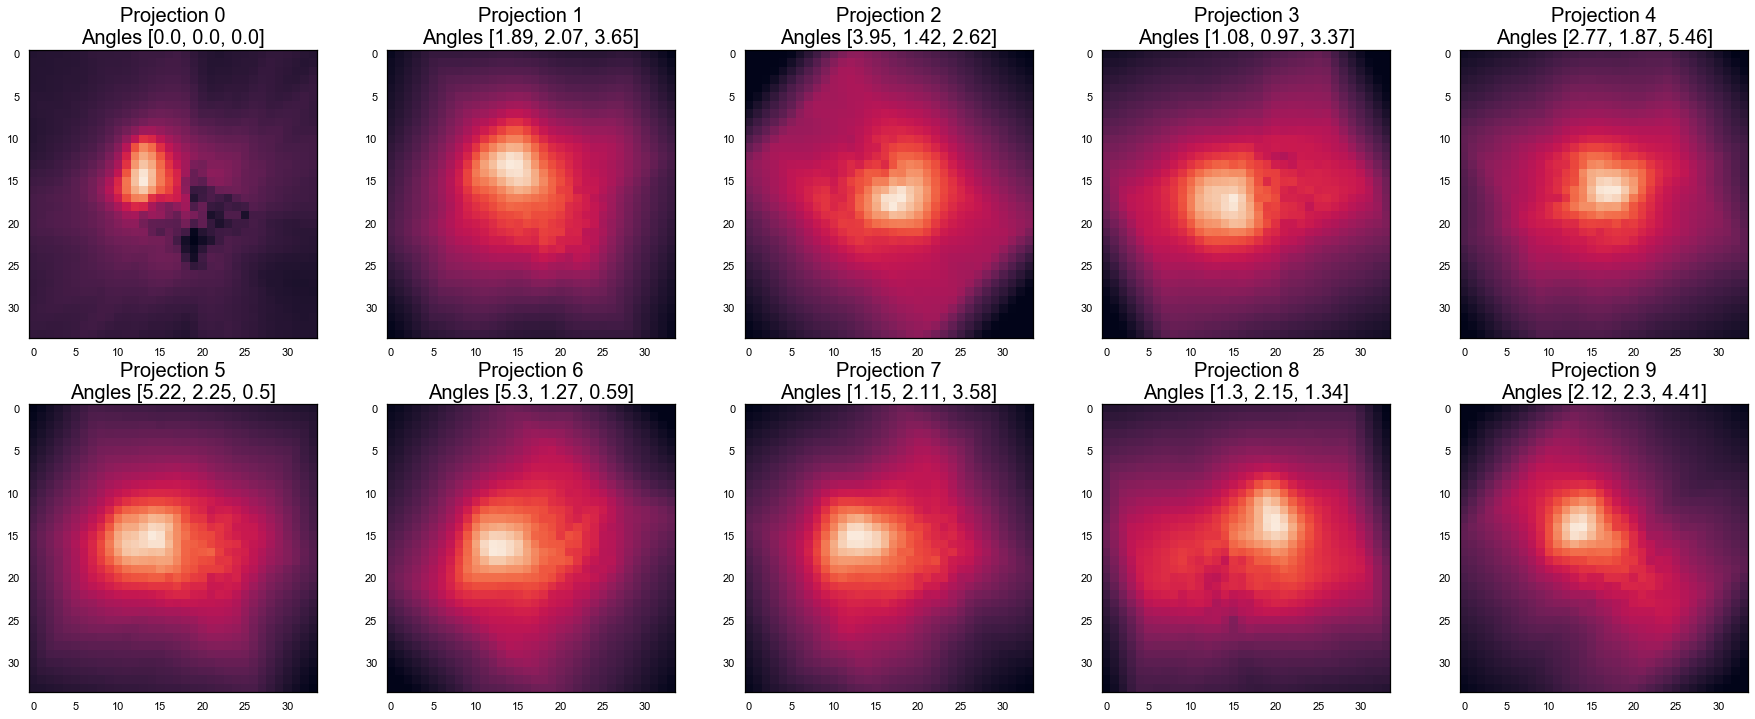

Q 69322912.01606897
delta Q 0.0
Q 70195967.63954735
delta Q 873055.6234783828
Q 71074687.45846084
delta Q 878719.8189134896
Q 71959128.53040493
delta Q 884441.0719440877
Q 72849345.29434216
delta Q 890216.7639372349
Q 73745397.73992336
delta Q 896052.4455811977
Q 74647340.93951994
delta Q 901943.1995965838
Q 75555234.30957182
delta Q 907893.3700518757
Q 76469133.23941413
delta Q 913898.9298423082
Q 77389102.55752565
delta Q 919969.318111524
Q 78315193.16779731
delta Q 926090.6102716625
Q 79247468.0158721
delta Q 932274.8480747938
Q 80185986.96396105
delta Q 938518.948088944
Q 81130806.56953053
delta Q 944819.6055694818
Q 82081990.2209335
delta Q 951183.6514029652
Q 83039594.95126003
delta Q 957604.7303265333
Q 84003683.91894406
delta Q 964088.9676840305
Q 84974312.87543531
delta Q 970628.9564912468
Q 85951544.25511591
delta Q 977231.3796806037
Q 86935440.15376173
delta Q 983895.8986458182
Q 87926059.0297422
delta Q 990618.8759804666
Q 88923462.01293312
delta Q 997402.9831909239
Q 89927

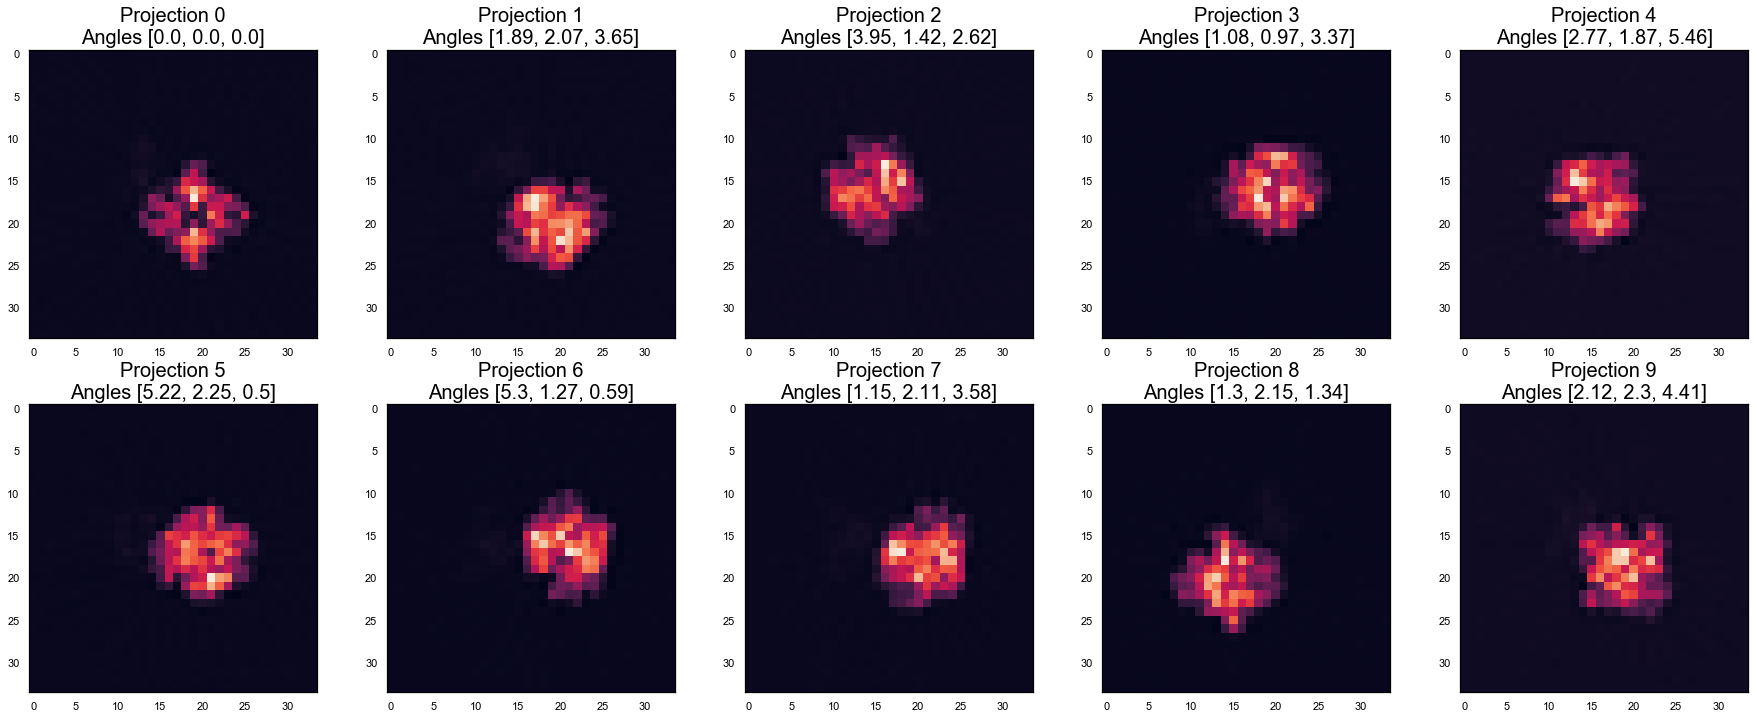

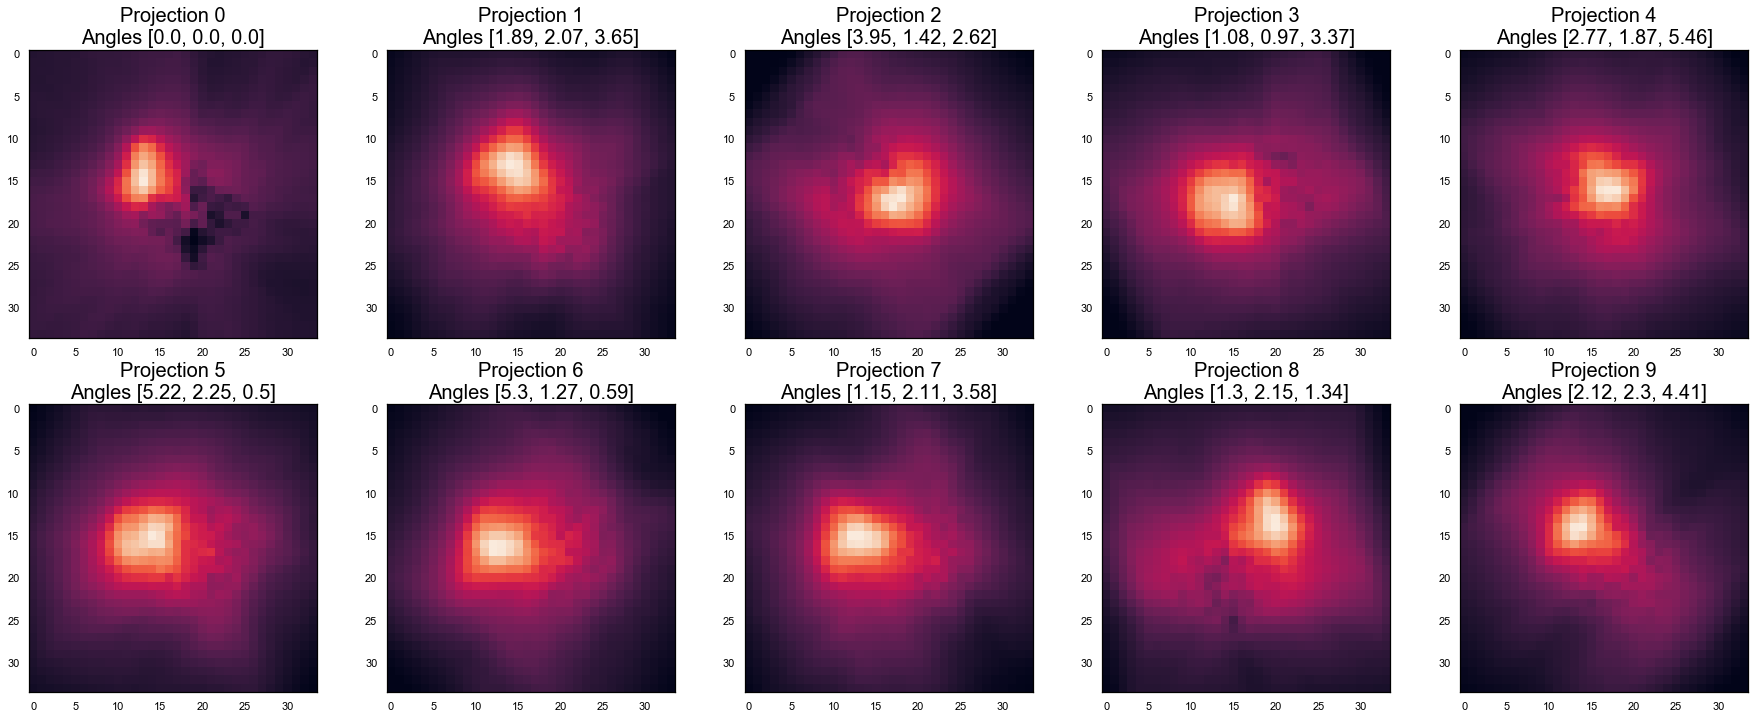

Q 121064284.37798557
delta Q 0.0
Q 122292137.30915688
delta Q 1227852.931171313
Q 123528485.3207165
delta Q 1236348.0115596205
Q 124773373.94958867
delta Q 1244888.628872171
Q 126026851.76395833
delta Q 1253477.8143696636
Q 127288954.7266991
delta Q 1262102.962740764
Q 128559722.0646635
delta Q 1270767.3379644006
Q 129839204.47113289
delta Q 1279482.4064693898
Q 131127434.6340358
delta Q 1288230.1629029065
Q 132424448.21340643
delta Q 1297013.5793706328
Q 133730291.98439747
delta Q 1305843.7709910423
Q 135044996.0198691
delta Q 1314704.0354716182
Q 136368598.86955595
delta Q 1323602.849686861
Q 137701131.03428343
delta Q 1332532.1647274792
Q 139042627.25332427
delta Q 1341496.2190408409
Q 140393120.211173
delta Q 1350492.9578487277
Q 141752642.80762503
delta Q 1359522.5964520276
Q 143121221.00345868
delta Q 1368578.1958336532
Q 144498884.76391795
delta Q 1377663.760459274
Q 145885663.64265305
delta Q 1386778.8787350953
Q 147281581.80663794
delta Q 1395918.1639848948
Q 148686666.1760541

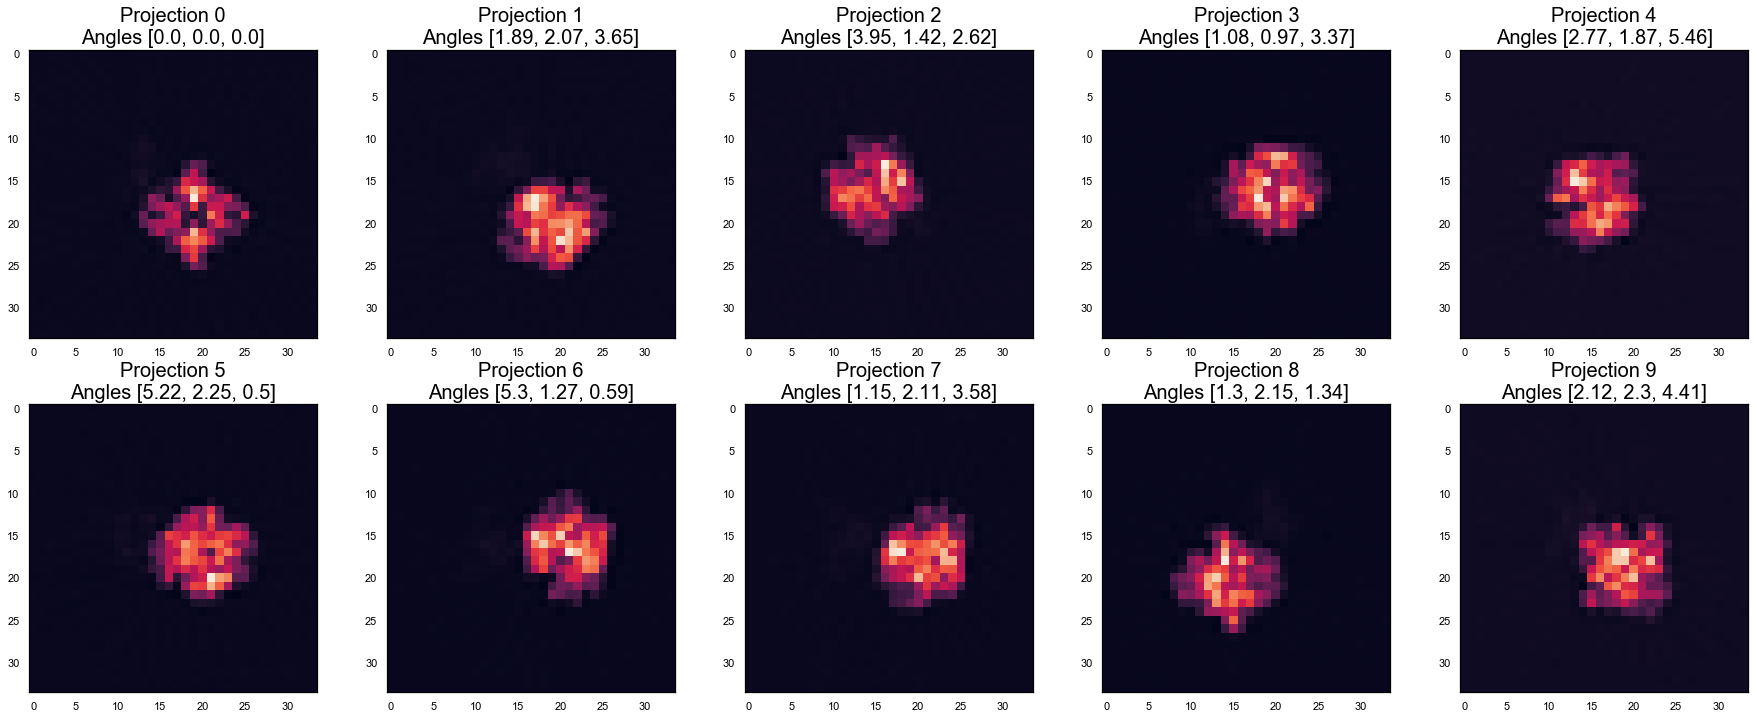

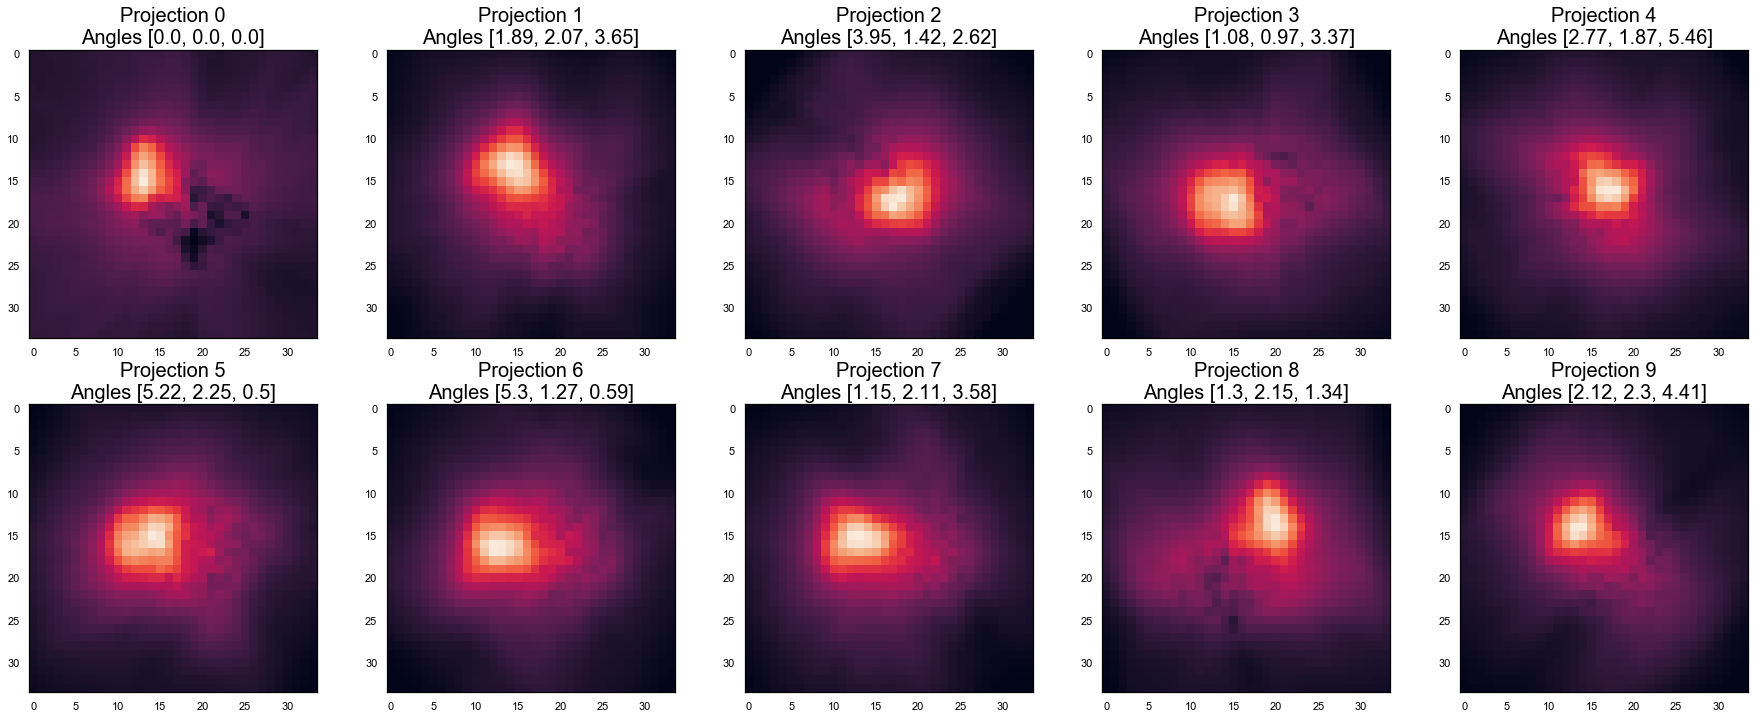

Q 193497296.7660242
delta Q 0.0
Q 195184013.91738975
delta Q 1686717.1513655484
Q 196880187.34037706
delta Q 1696173.422987312
Q 198585816.72112527
delta Q 1705629.3807482123
Q 200300895.6436801
delta Q 1715078.9225548208
Q 202025419.73192978
delta Q 1724524.0882496834
Q 203759382.82133925
delta Q 1733963.0894094706
Q 205502785.65433392
delta Q 1743402.8329946697
Q 207255614.77808514
delta Q 1752829.123751223
Q 209017867.38251483
delta Q 1762252.604429692
Q 210789531.40173385
delta Q 1771664.019219011
Q 212570606.20832142
delta Q 1781074.8065875769
Q 214361083.5428415
delta Q 1790477.3345200717
Q 216160950.3522062
delta Q 1799866.8093647063
Q 217970202.47441295
delta Q 1809252.1222067475
Q 219788831.54983705
delta Q 1818629.075424105
Q 221616826.4151224
delta Q 1827994.865285337
Q 223454178.14653224
delta Q 1837351.7314098477
Q 225300877.5435479
delta Q 1846699.397015661
Q 227156919.0858938
delta Q 1856041.5423459113
Q 229022288.9559423
delta Q 1865369.8700484931
Q 230896979.3060334
de

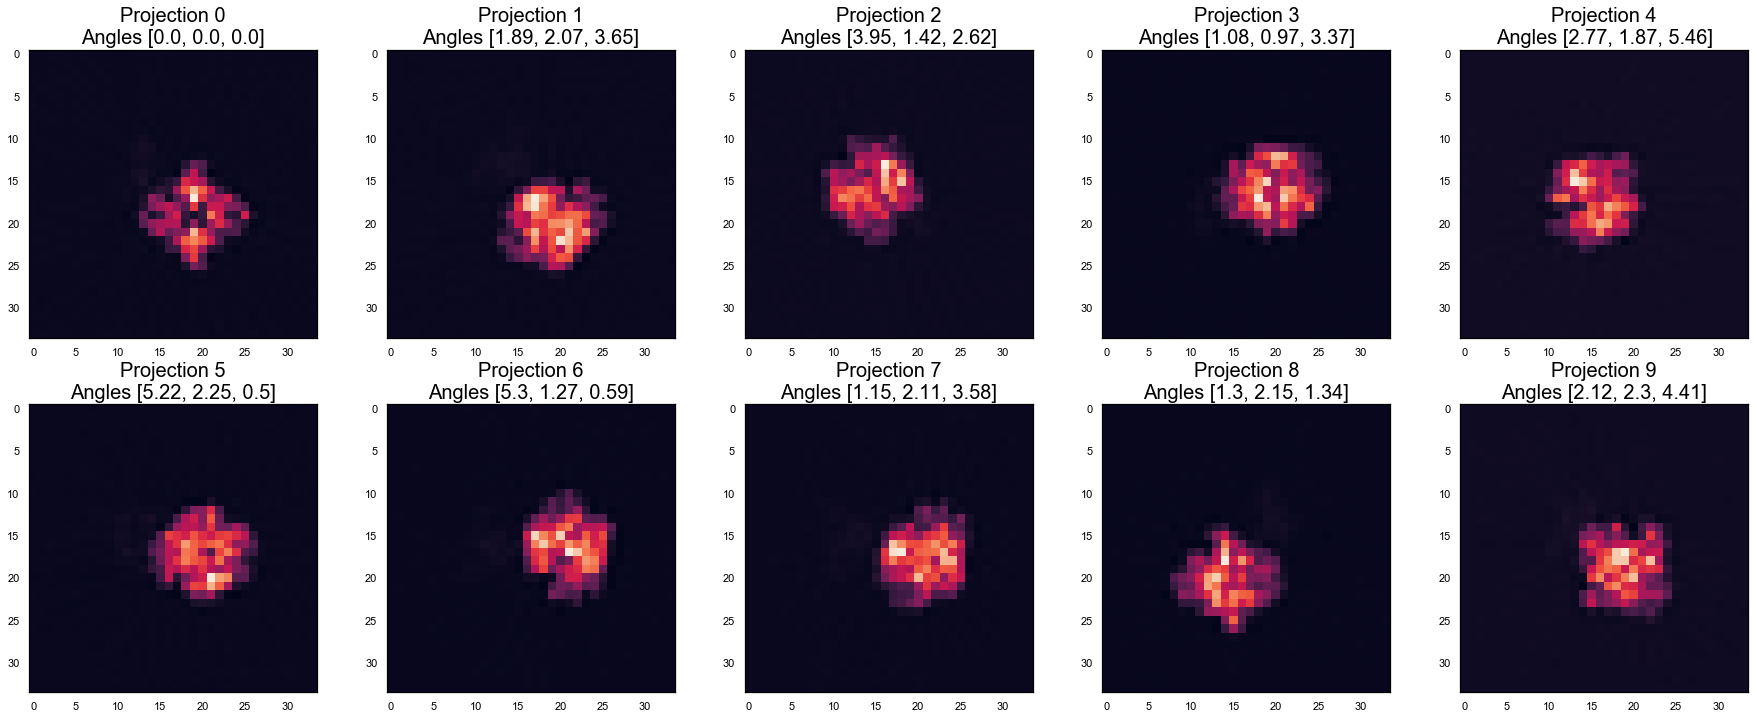

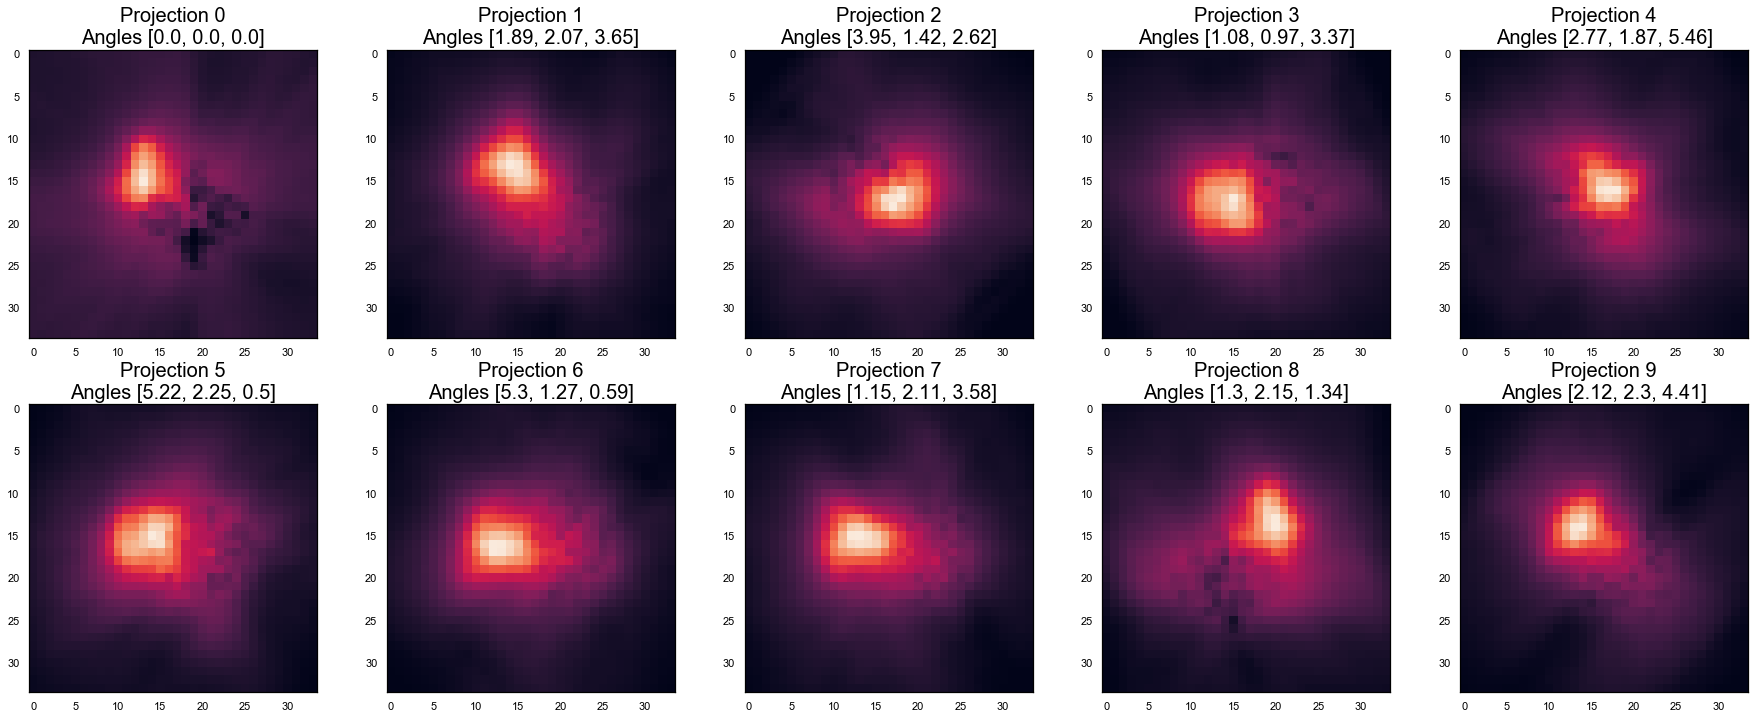

Q 289275734.6883124
delta Q 0.0
Q 291426048.66267216
delta Q 2150313.9743597507
Q 293585480.597475
delta Q 2159431.93480283
Q 295754019.4903122
delta Q 2168538.8928372264
Q 297931675.4211388
delta Q 2177655.9308266044
Q 300118451.0516221
delta Q 2186775.6304832697
Q 302314347.0341936
delta Q 2195895.9825714827
Q 304519366.20524657
delta Q 2205019.1710529923
Q 306733523.8745443
delta Q 2214157.6692977548
Q 308956818.03617966
delta Q 2223294.1616353393
Q 311189255.76438826
delta Q 2232437.7282086015
Q 313430844.89941865
delta Q 2241589.135030389
Q 315681605.094255
delta Q 2250760.1948363185
Q 317941537.3415423
delta Q 2259932.247287333
Q 320210656.05541015
delta Q 2269118.713867843
Q 322488966.67902553
delta Q 2278310.623615384
Q 324776490.32256824
delta Q 2287523.643542707
Q 327073242.8124773
delta Q 2296752.489909053
Q 329379236.56256783
delta Q 2305993.7500905395
Q 331694491.4927525
delta Q 2315254.9301846623
Q 334019020.30714285
delta Q 2324528.8143903613
Q 336352845.8889273
delta Q 

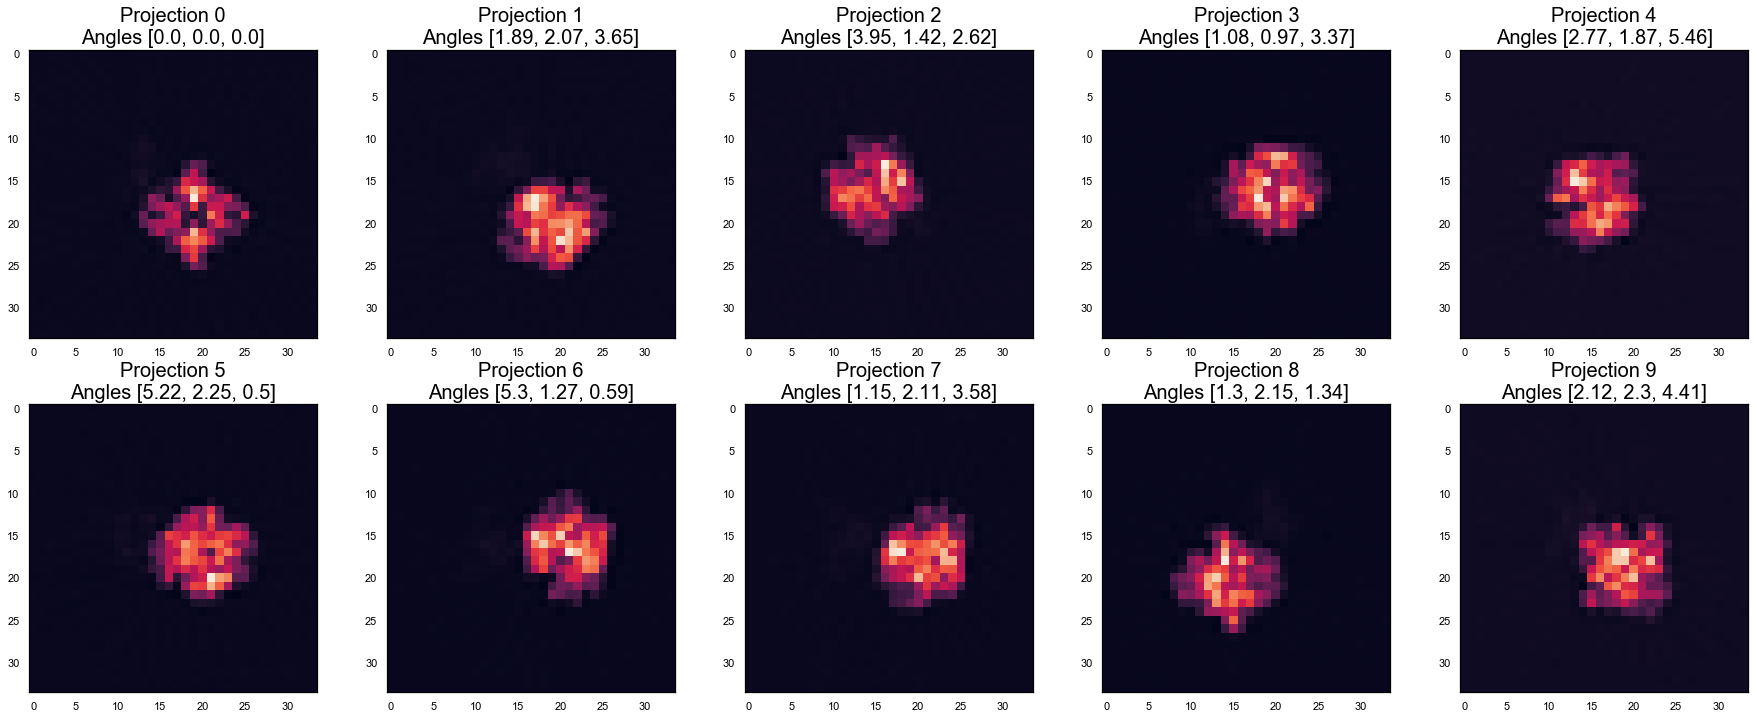

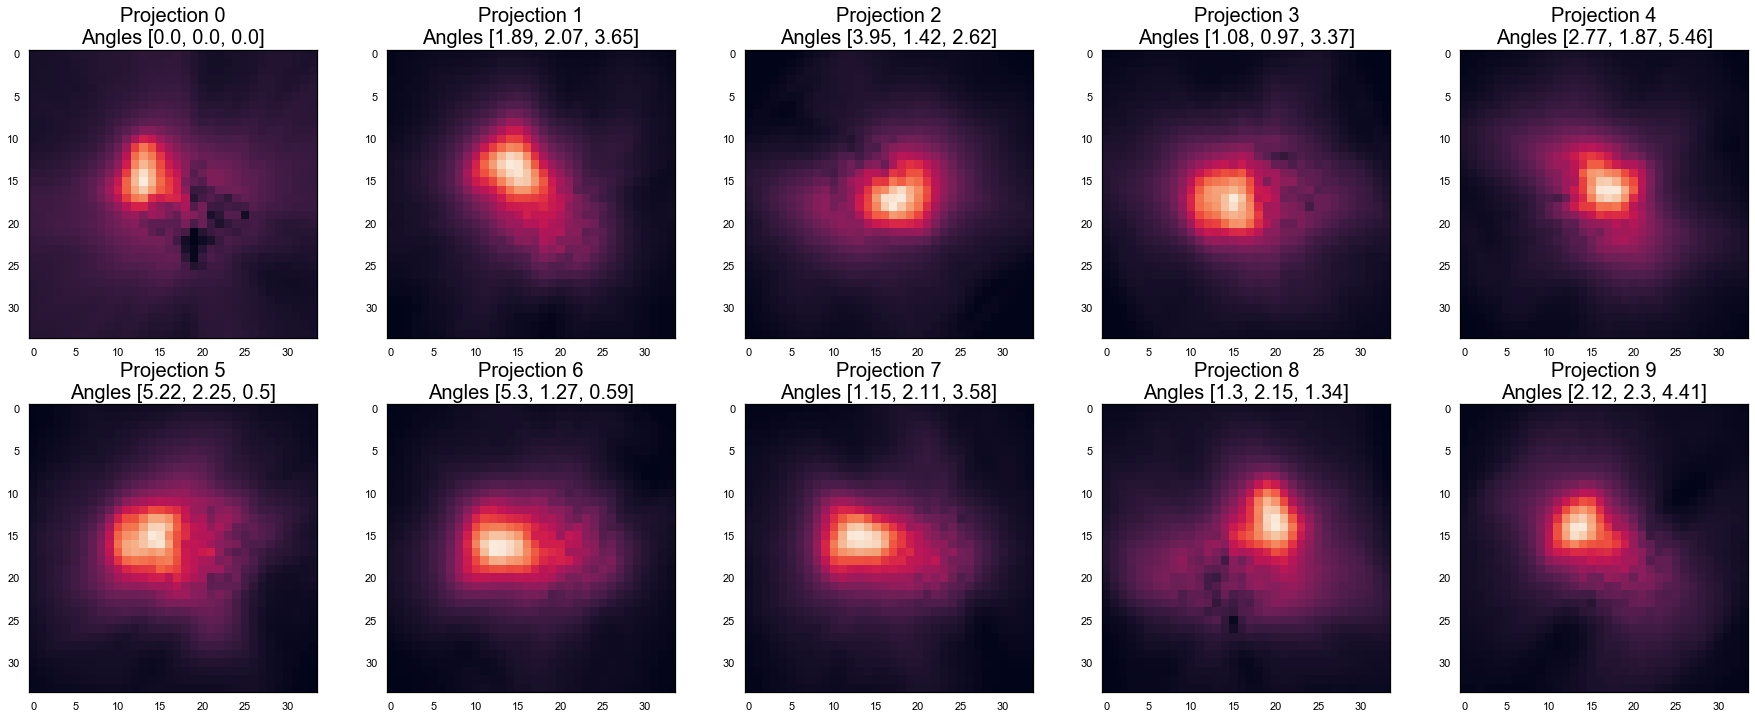

Q 408207769.2069658
delta Q 0.0
Q 410835476.9319026
delta Q 2627707.7249367833
Q 413473685.69725865
delta Q 2638208.765356064
Q 416122442.6980289
delta Q 2648757.000770271
Q 418781808.4101395
delta Q 2659365.712110579
Q 421451844.43616575
delta Q 2670036.026026249
Q 424132608.36406183
delta Q 2680763.9278960824
Q 426824160.08022916
delta Q 2691551.7161673307
Q 429526559.9460153
delta Q 2702399.865786135
Q 432239864.7290362
delta Q 2713304.7830209136
Q 434964136.9684142
delta Q 2724272.2393779755
Q 437699442.1507504
delta Q 2735305.182336211
Q 440445840.112278
delta Q 2746397.961527586
Q 443203387.6298932
delta Q 2757547.517615199
Q 445972153.09408915
delta Q 2768765.4641959667
Q 448752200.86708343
delta Q 2780047.77299428
Q 451543587.6596067
delta Q 2791386.792523265
Q 454346374.767924
delta Q 2802787.1083173156
Q 457160625.17823476
delta Q 2814250.4103107452
Q 459986404.38303494
delta Q 2825779.2048001885
Q 462823767.2564436
delta Q 2837362.873408675
Q 465672771.68718445
delta Q 28490

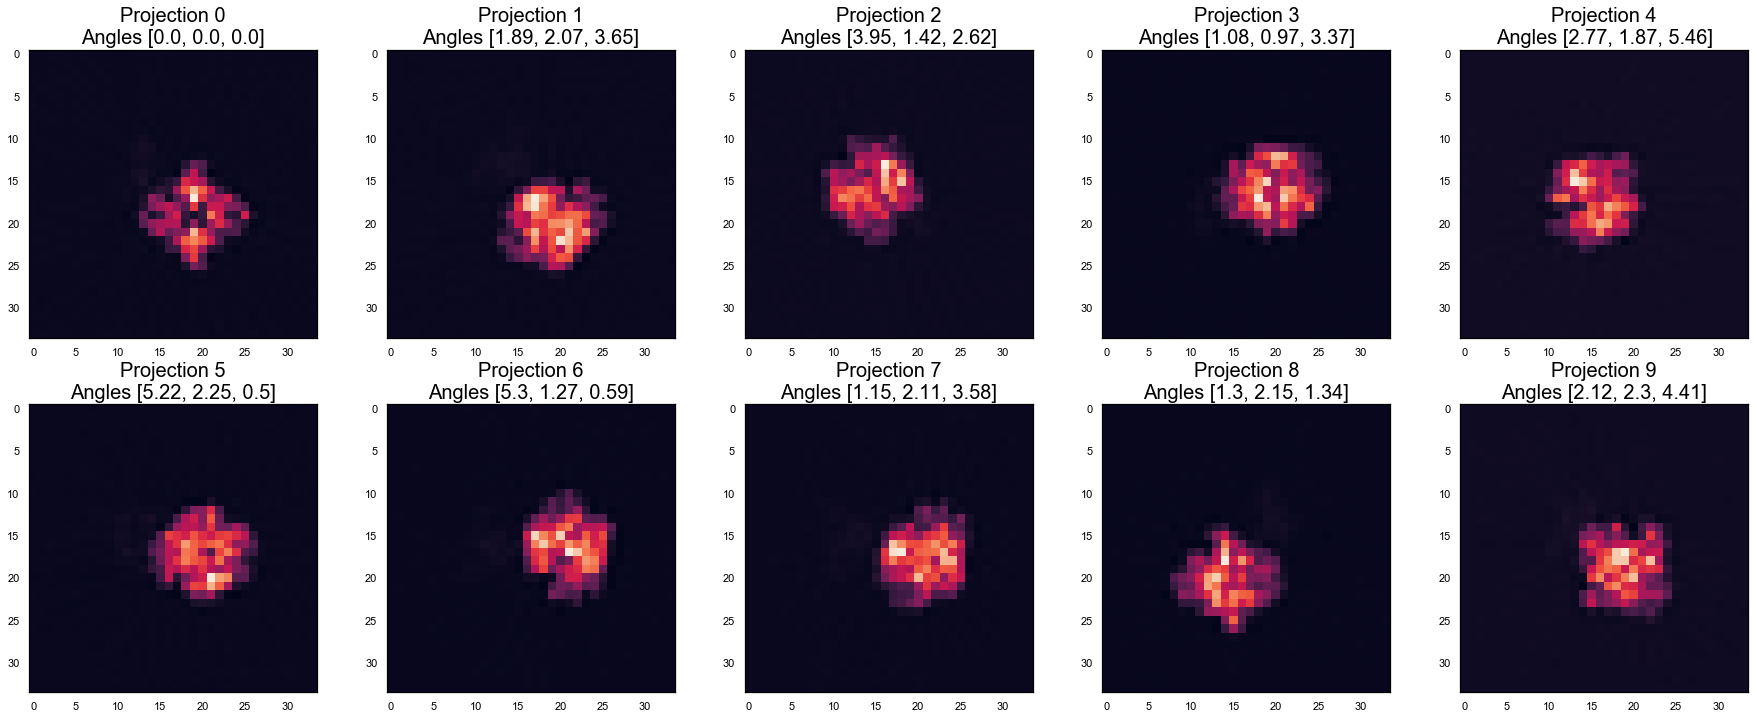

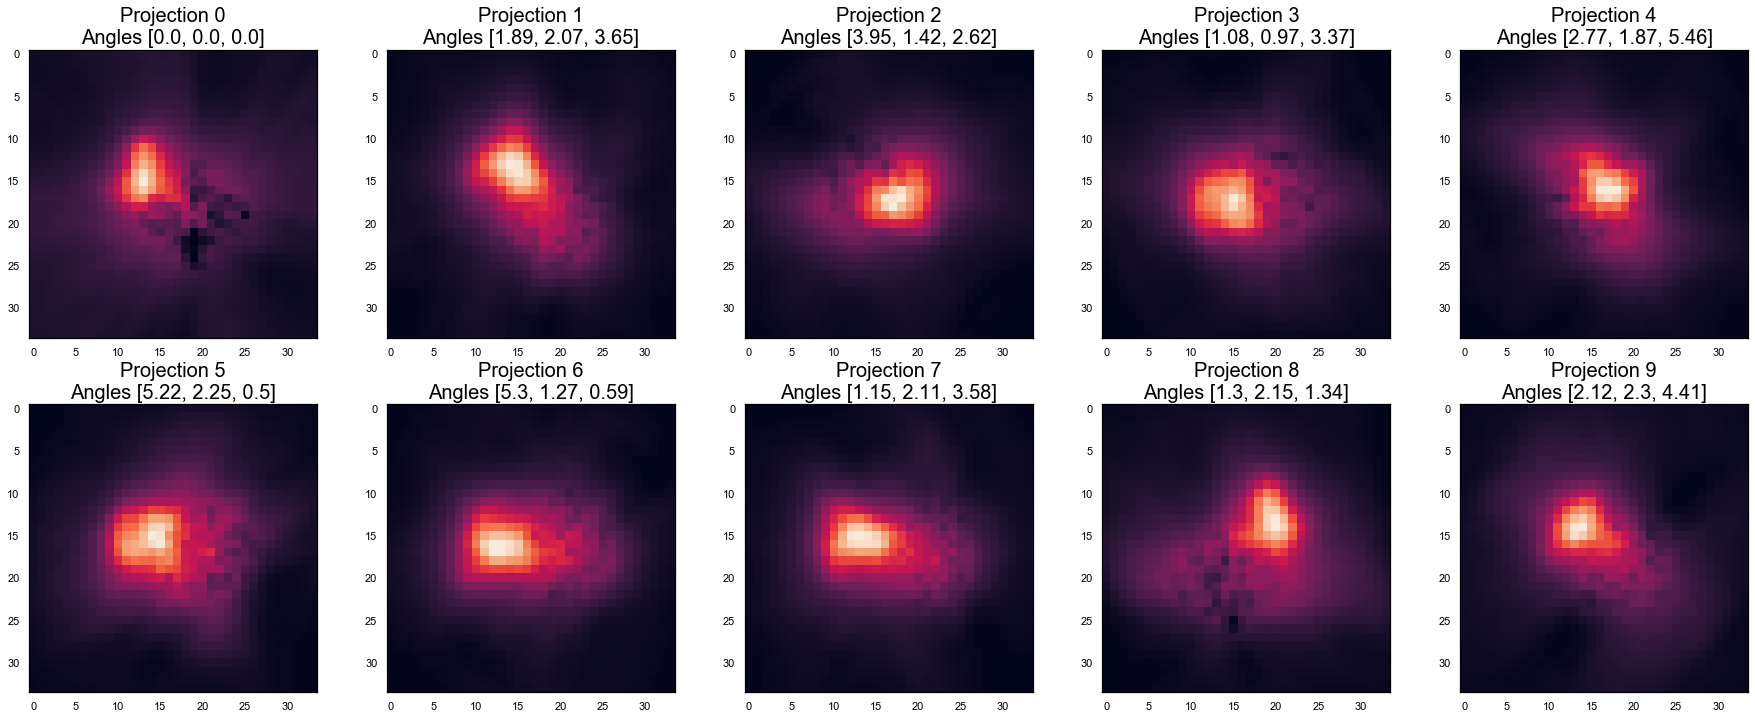

Q 553570364.6093686
delta Q 0.0
Q 556787042.7533089
delta Q 3216678.1439403296
Q 560016018.4597769
delta Q 3228975.706467986
Q 563257238.0595253
delta Q 3241219.599748373
Q 566510647.9138452
delta Q 3253409.85431993
Q 569776170.136632
delta Q 3265522.222786784
Q 573053743.6555762
delta Q 3277573.5189442635
Q 576343283.445529
delta Q 3289539.789952755
Q 579644703.1692705
delta Q 3301419.7237415314
Q 582957907.4192531
delta Q 3313204.2499825954
Q 586282786.5972323
delta Q 3324879.177979231
Q 589619227.6938047
delta Q 3336441.096572399
Q 592967118.1271273
delta Q 3347890.433322549
Q 596326327.2715745
delta Q 3359209.1444472075
Q 599696718.0394323
delta Q 3370390.76785779
Q 603078143.5706635
delta Q 3381425.531231165
Q 606470444.6964575
delta Q 3392301.125794053
Q 609873460.6102874
delta Q 3403015.9138299227
Q 613287022.6525311
delta Q 3413562.042243719
Q 616710938.0184287
delta Q 3423915.3658975363
Q 620145025.2762626
delta Q 3434087.2578339577
Q 623589077.3576881
delta Q 3444052.08142542

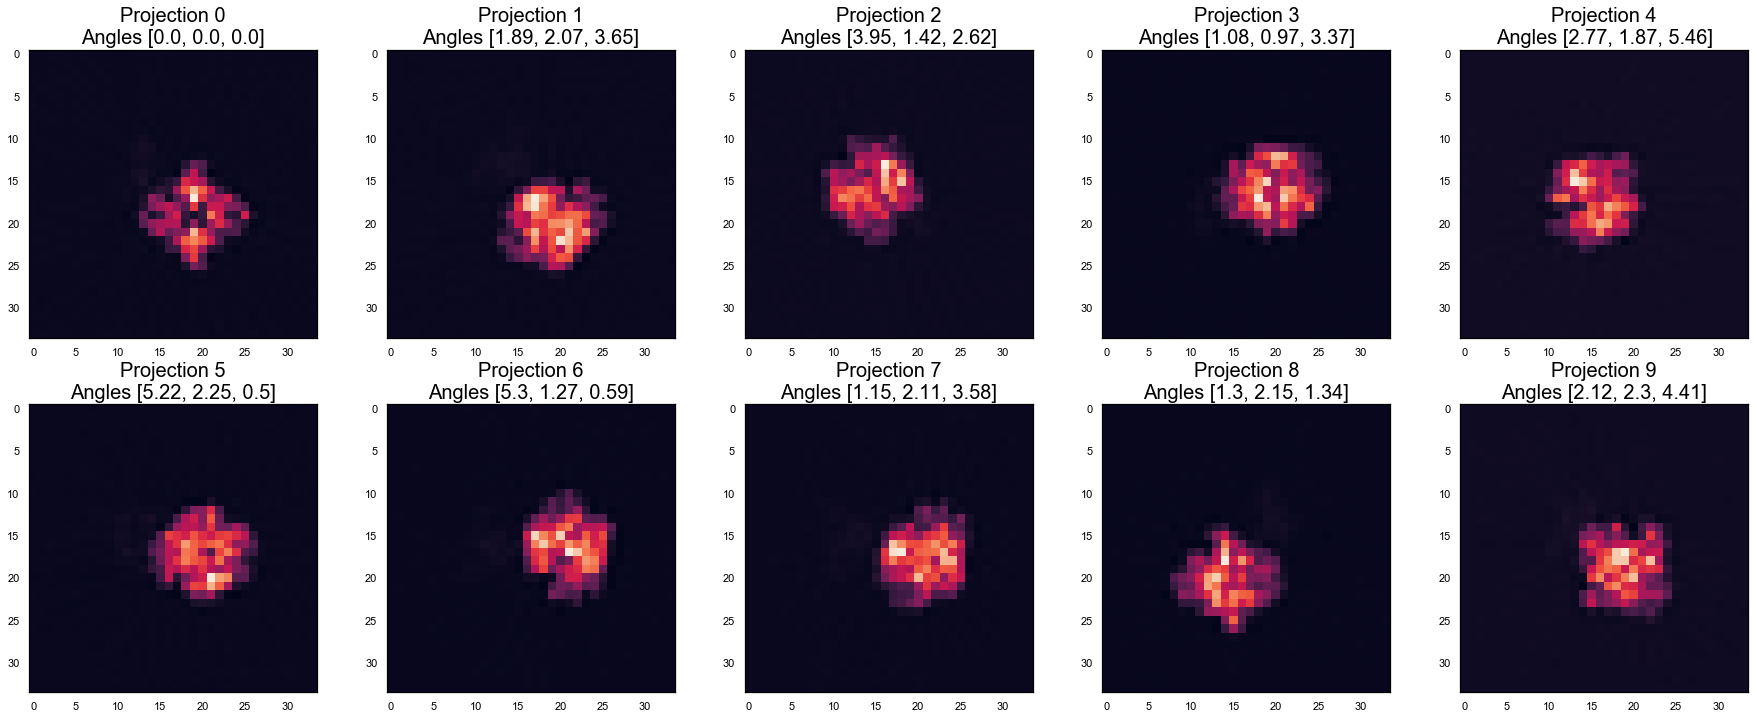

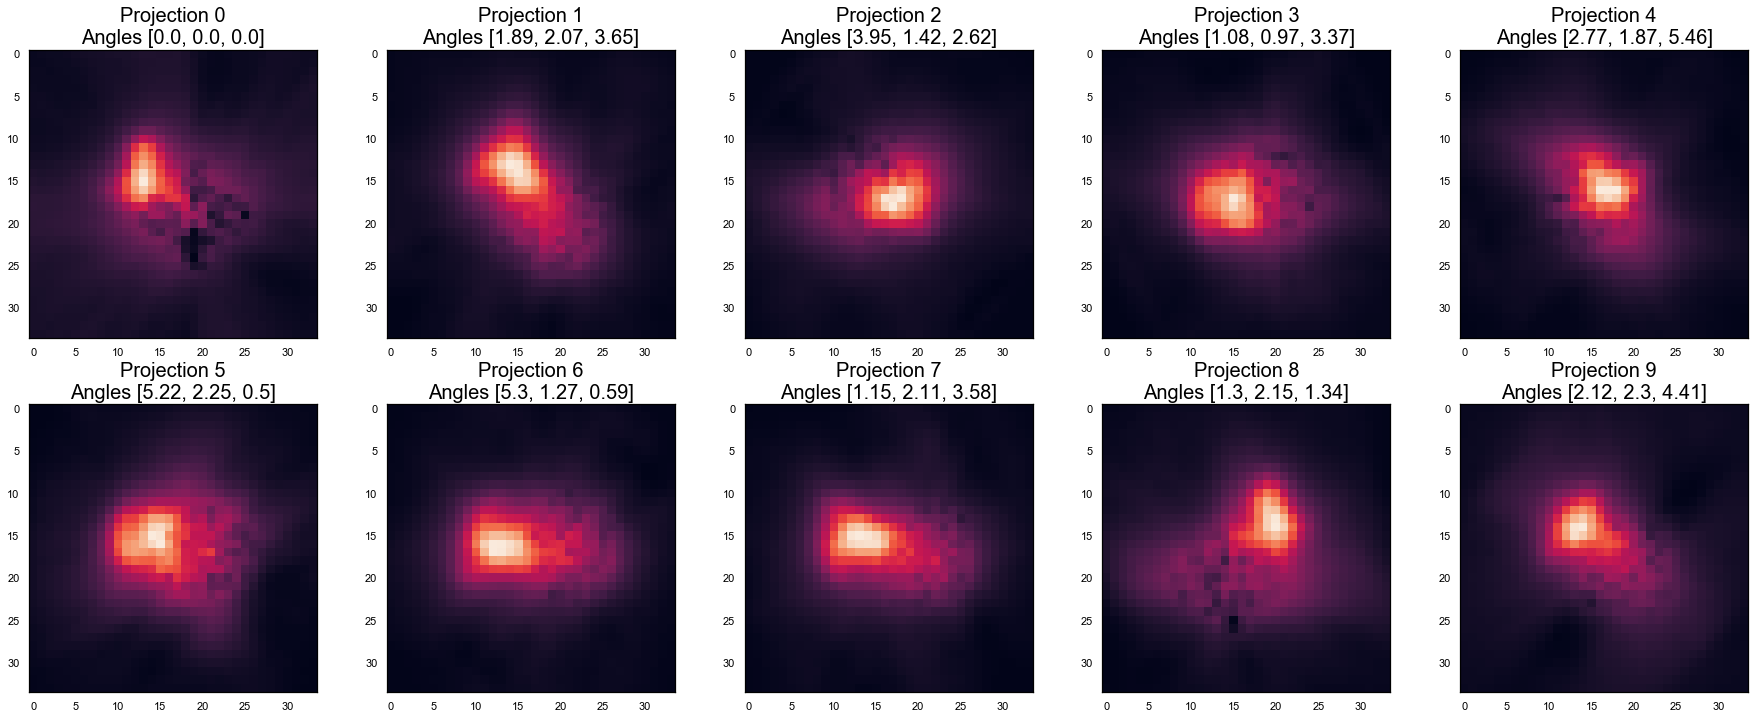

Q 726553988.2152805
delta Q 0.0
Q 730156464.0441676
delta Q 3602475.828887105
Q 733758063.6933798
delta Q 3601599.649212122
Q 737358313.0802158
delta Q 3600249.386836052
Q 740956734.418071
delta Q 3598421.33785522
Q 744552833.4318482
delta Q 3596099.013777137
Q 748146118.56417
delta Q 3593285.1323218346
Q 751736091.4808038
delta Q 3589972.9166338444
Q 755322245.1148471
delta Q 3586153.6340432167
Q 758904075.4764243
delta Q 3581830.3615772724
Q 762481074.6967044
delta Q 3576999.220280051
Q 766052720.7237716
delta Q 3571646.0270671844
Q 769618503.5181875
delta Q 3565782.794415951
Q 773177894.3442315
delta Q 3559390.8260439634
Q 776730370.4403589
delta Q 3552476.096127391
Q 780275404.6028844
delta Q 3545034.1625255346
Q 783812473.874194
delta Q 3537069.271309614
Q 787341041.6775093
delta Q 3528567.803315282
Q 790860592.1645952
delta Q 3519550.4870859385
Q 794370584.6104723
delta Q 3509992.445877075
Q 797870474.8280137
delta Q 3499890.217541337
Q 801359742.9544394
delta Q 3489268.126425743

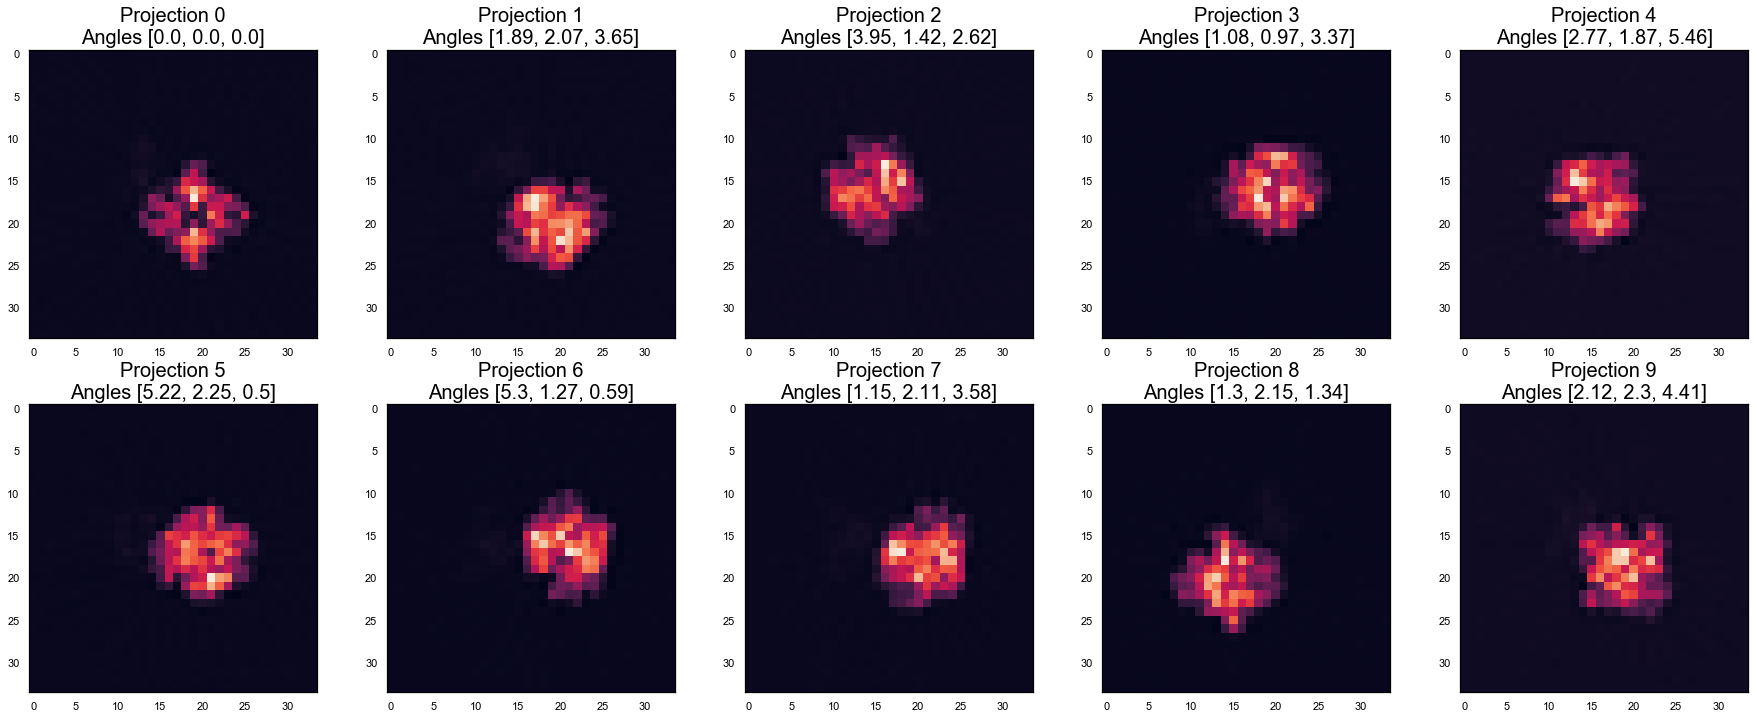

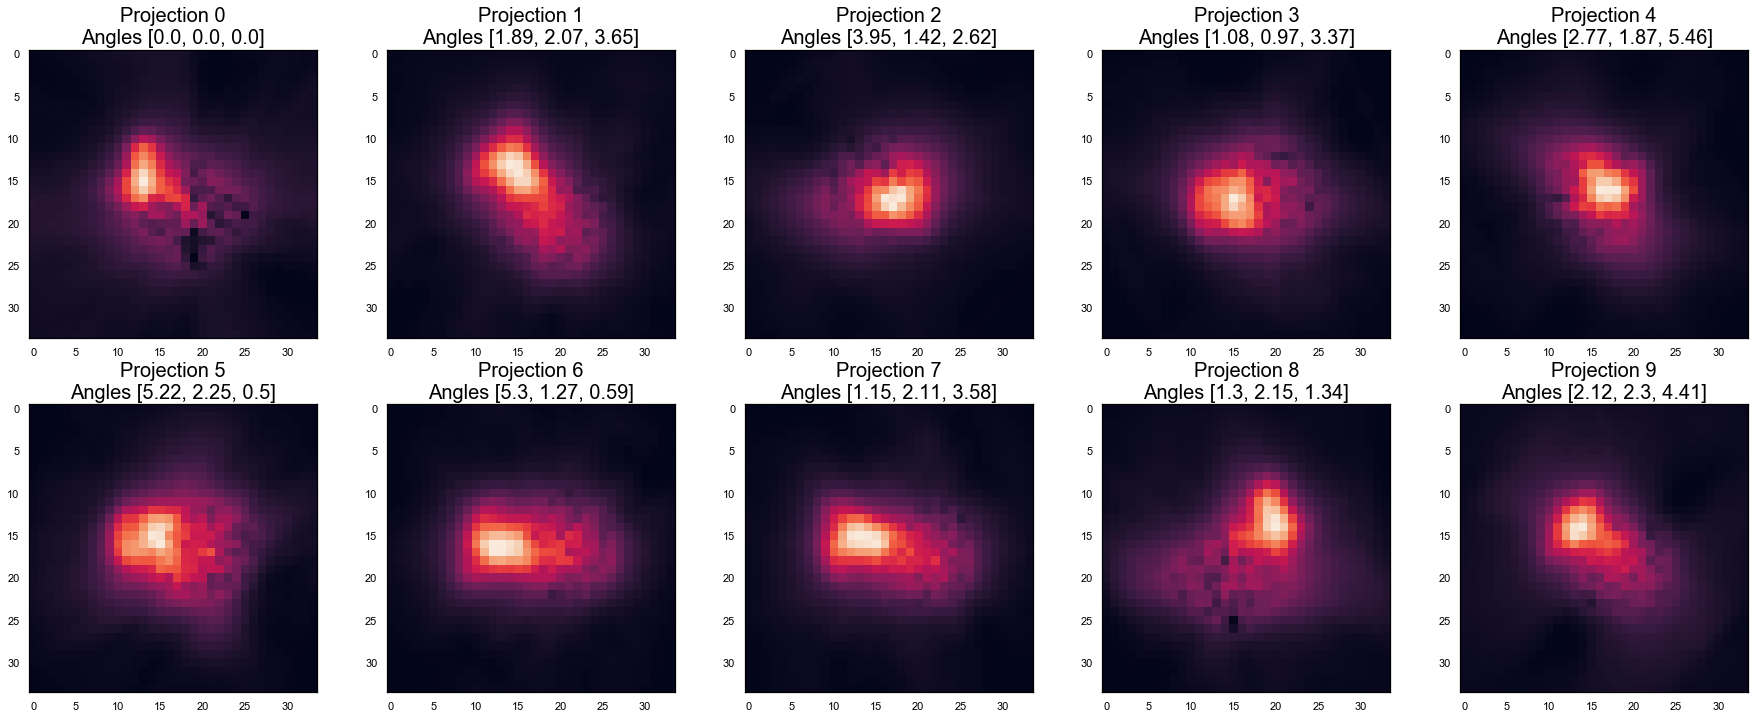

Q 895587452.5709265
delta Q 0.0
Q 898520187.0460868
delta Q 2932734.475160241
Q 901427128.1509129
delta Q 2906941.1048260927
Q 904307873.0063536
delta Q 2880744.855440736
Q 907162034.6928793
delta Q 2854161.6865257025
Q 909989210.225994
delta Q 2827175.5331146717
Q 912789033.2369996
delta Q 2799823.01100564
Q 915561112.862157
delta Q 2772079.6251573563
Q 918305091.1618245
delta Q 2743978.2996674776
Q 921020602.0650082
delta Q 2715510.9031836987
Q 923707309.1365988
delta Q 2686707.071590662
Q 926364861.2264898
delta Q 2657552.089890957
Q 928992915.8043376
delta Q 2628054.5778478384
Q 931591154.414919
delta Q 2598238.610581398
Q 934159260.575233
delta Q 2568106.160313964
Q 936696914.8523382
delta Q 2537654.277105212
Q 939203820.8233966
delta Q 2506905.9710583687
Q 941679678.2069318
delta Q 2475857.383535266
Q 944124202.7694991
delta Q 2444524.562567234
Q 946537123.6217074
delta Q 2412920.852208376
Q 948918161.1051391
delta Q 2381037.483431697
Q 951267054.7383405
delta Q 2348893.633201360

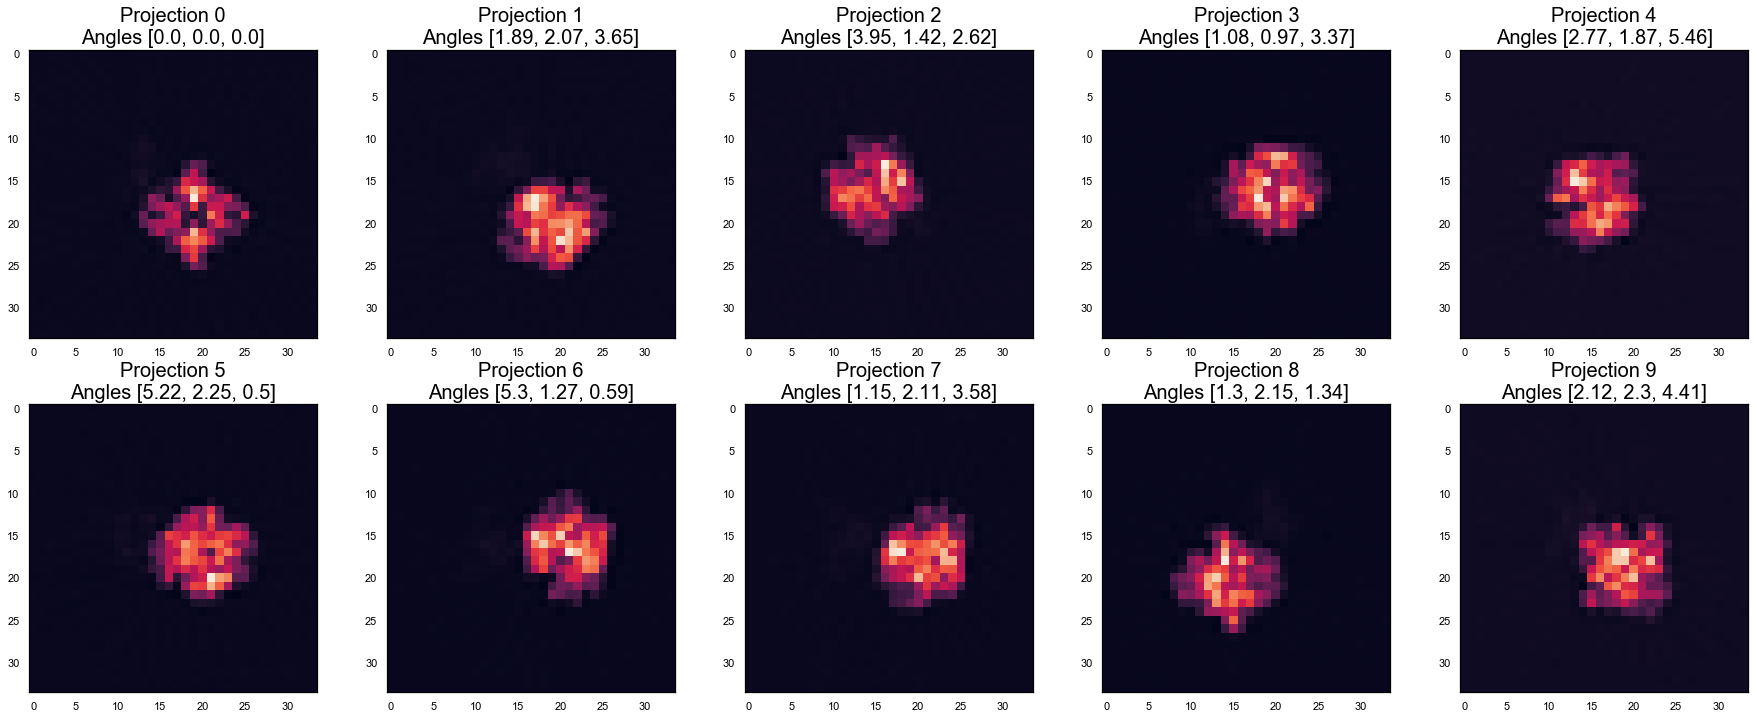

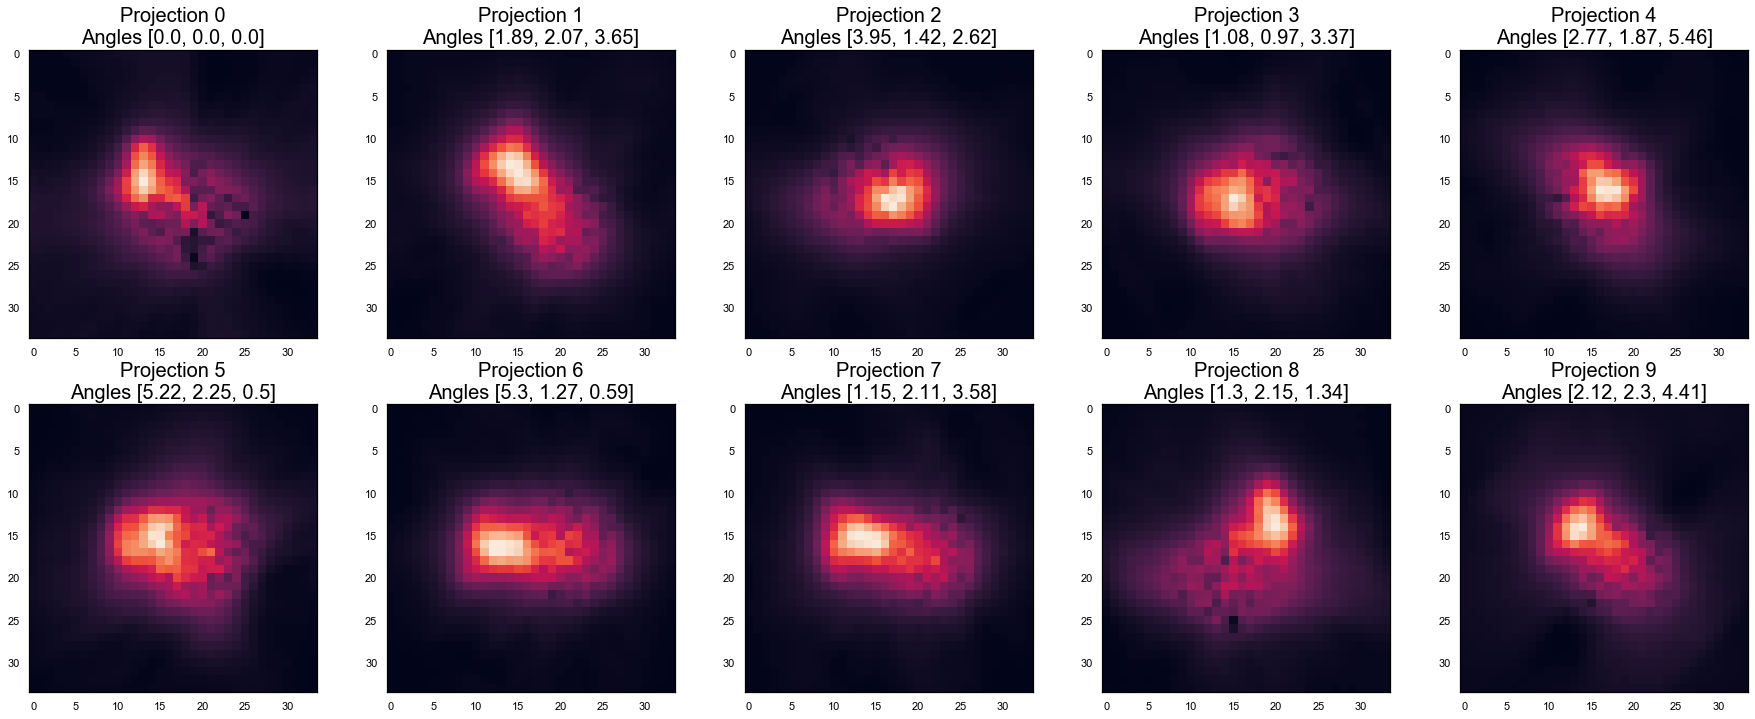

Q 1004519834.4173998
delta Q 0.0
Q 1005822845.909201
delta Q 1303011.491801262
Q 1007089543.9667356
delta Q 1266698.0575345755
Q 1008319913.1620501
delta Q 1230369.1953145266
Q 1009513943.8868525
delta Q 1194030.7248023748
Q 1010671624.274124
delta Q 1157680.3872715235
Q 1011792963.5985117
delta Q 1121339.3243876696
Q 1012877971.0331222
delta Q 1085007.434610486
Q 1013926655.9255604
delta Q 1048684.8924381733
Q 1014939033.5199008
delta Q 1012377.5943404436
Q 1015915142.1365446
delta Q 976108.6166437864
Q 1016855006.9295163
delta Q 939864.7929717302
Q 1017758664.6698778
delta Q 903657.7403614521
Q 1018626155.4567604
delta Q 867490.7868826389
Q 1019457538.2258179
delta Q 831382.7690575123
Q 1020252855.6850948
delta Q 795317.4592769146
Q 1021012179.7210395
delta Q 759324.0359447002
Q 1021735571.1523085
delta Q 723391.4312689304
Q 1022423093.1102992
delta Q 687521.9579907656
Q 1023074831.1659849
delta Q 651738.0556856394
Q 1023690856.1916541
delta Q 616025.0256692171
Q 1024271259.3554004
d

In [ ]:
_, num_image , n_component = 116, 5000 , 2
print(P3R.mu.shape)
print(ProjSize1)
Mus = P3R.mu.reshape(1, ProjSize1, ProjSize1, ProjSize1)
P3RM = PCA_3d_Recon_recurssive(ProjSize1, num_image, n_component,Mus )
P3RM.Au_s(angles2)
print(P3RM.Aus.shape)
#P3RM.Plot_mu_by_projection(angles2)
#P3RM.Expectation(new_projection , angles2)
#P3RM.Maximization(new_projection , angles2)
P3RM.fit(new_projection , angles2)

In [ ]:
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)
#P3RM.fit(new_projection , angles2)

In [31]:
#Check ro_j whether the same

print(True_z2.reshape(-1)[:5])
print(P3RM.ro[:5,0])
print(True_z1.reshape(-1)[:5])
print(P3RM.ro[:5,1])

print(P3RM.Mus.shape)
vec1 = P3RM.Mus[0].reshape(-1)
vec2 = P3RM.Mus[1].reshape(-1)
print(np.sum(vec1*vec2))
print(np.dot(vec1 ,vec1) /np.linalg.norm(vec1) / np.linalg.norm(vec1))
print(np.sum(vec1*vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2))

[ 2.08751719 -0.25337916 -0.36445553 -0.25359546  0.05210942]
[ 3.21404745 -0.26473339 -0.97069626 -0.60095073 -0.34542855]
[-0.02958446  0.44864975 -1.35269207 -0.68887292 -1.51650291]
[-0.26381879  0.24024991 -0.04960803 -0.12711447 -0.16774667]
(2, 25, 25, 25)
0.0012066971638782348
1.0
0.05023856382097017


In [ ]:
print(np.linalg.norm(Vol2))
print(np.linalg.norm(Vol1))
print(np.linalg.norm(P3R.mu))

In [ ]:
#print(P3R.mu)
ProjSize = ProjSize1
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [ ]:
print('the 2th component')
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
print(curremt_mu.shape)
print('P3RM.Mus[-1]',np.mean(P3RM.Mus[-1]))
print('+P3RM.Mus[0]', np.mean(P3RM.Mus[0]))
print(np.sum(np.abs(P3RM.Mus[-1]+P3RM.Mus[0])))

In [ ]:
curremt_mu = P3RM.Mus[0].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)
curremt_mu = P3RM.Mus[-1].reshape(P3RM.ProjSize , P3RM.ProjSize,P3RM.ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], P3RM.ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(-CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=1, ncols=5)